# Creating Groundwater Flow Models from Hec RAS Outputs Using Flopy

In [113]:
# make sure you're in virtual environment by running ".\\.venv\Scripts\activate" in terminal
#-----------------------Importing Libraries-----------------------#
import os
import flopy
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import pandas as pd
import rasterio
import pyproj
import shutil
import random
import pathlib as pl
from pathlib import Path
from rasterio.crs import CRS
from rasterio.plot import show
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.transform import from_bounds
from rasterio.transform import rowcol
from rasterio.mask import mask
from shapely.geometry import box, Point, Polygon, LineString
from flopy.utils.binaryfile import HeadFile
from scipy.interpolate import griddata
from pprint import pformat
from flopy.plot.styles import styles
from matplotlib.lines import Line2D
from flopy.mf6 import MFSimulation
from matplotlib import cbook, cm
from matplotlib.colors import LightSource
from modflow_devtools.misc import get_env, timed

Reprojected raster saved as reprojected_terrain_raster.tif
Reprojected raster saved as reprojected_water_surface_elevation_raster.tif
Cropped water surface elevation raster saved as cropped_water_surface_elevation_raster.tif


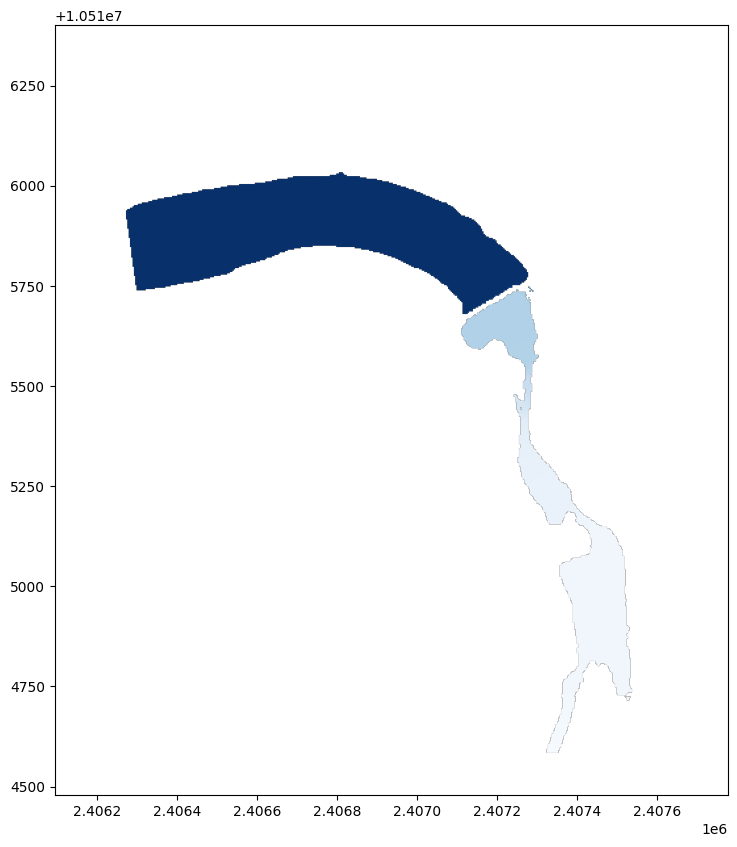

In [114]:
#----------------------Pre-Processing Steps ----------------------#
## Data Paths
water_surface_elevation_raster = r"C:\Users\u4eeevmq\Documents\Python\test_12_18_2024\CH00365\GMS\WSE (Max).USGS_1m_FebApril2018_DEM.U_USGS-3DEP_dtm_hyrdo_flattened_20240412.2041_1.tif"
terrain_elevation_raster = r"C:\Users\u4eeevmq\Documents\Python\test_12_18_2024\CH00365\GMS\BlendedTerrain.LoweredTerrain.tif"
ground_water_domain_shapefile = r"C:\Users\u4eeevmq\Documents\Python\test_12_18_2024\InputShapefiles\GWDomain.shp"
left_boundary_floodplain = r"C:\Users\u4eeevmq\Documents\Python\test_12_18_2024\InputShapefiles\L_FPL.shp"
right_boundary_floodplain = r"C:\Users\u4eeevmq\Documents\Python\test_12_18_2024\InputShapefiles\R_FPL.shp"

## Projection File Path
projection_file = r"C:\Users\u4eeevmq\Documents\Python\test_12_18_2024\CH00365\RAS\GIS_Data\102739_TX_central.prj"

## HEC-RAS CRS
hec_ras_crs = CRS.from_string(open(projection_file).read().strip())

# Load raster and shapefiles
#---------------------------------Terrain Elevation -----------------------------------------#
# Open the terrain raster
with rasterio.open(terrain_elevation_raster) as src:
    terrain_elevation = src.read(1)
    raster_transform = src.transform
    raster_crs = src.crs

    # Calculate the new transform and dimensions
    transform, width, height = calculate_default_transform(
        raster_crs, hec_ras_crs, src.width, src.height, *src.bounds
    )

    # Define metadata for the new raster
    new_meta = src.meta.copy()
    new_meta.update({
        "crs": hec_ras_crs,
        "transform": transform,
        "width": width,
        "height": height
    })

    # Define output file name
    output_raster = "reprojected_terrain_raster.tif"

    # Reproject and save
    with rasterio.open(output_raster, "w", **new_meta) as dst:
        reproject(
            source=rasterio.band(src, 1),
            destination=rasterio.band(dst, 1),
            src_transform=raster_transform,
            src_crs=raster_crs,
            dst_transform=transform,
            dst_crs=hec_ras_crs,
            resampling=Resampling.nearest
        )

print(f"Reprojected raster saved as {output_raster}")
#---------------------------------Water Surface Elevation -----------------------------------------#
# Open the input raster
with rasterio.open(water_surface_elevation_raster) as src:
    surface_elevation = src.read(1)
    raster_transform = src.transform
    raster_crs = src.crs

    # Calculate the new transform and dimensions
    transform, width, height = calculate_default_transform(
        raster_crs, hec_ras_crs, src.width, src.height, *src.bounds
    )
    
    # Define metadata for the new raster
    new_meta = src.meta.copy()
    new_meta.update({
        "crs": hec_ras_crs,
        "transform": transform,
        "width": width,
        "height": height
    })

    # Define output file name
    output_raster = "reprojected_water_surface_elevation_raster.tif"

    # Reproject and save
    with rasterio.open(output_raster, "w", **new_meta) as dst:
        reproject(
            source=rasterio.band(src, 1),
            destination=rasterio.band(dst, 1),
            src_transform=raster_transform,
            src_crs=raster_crs,
            dst_transform=transform,
            dst_crs=hec_ras_crs,
            resampling=Resampling.nearest
        )

print(f"Reprojected raster saved as {output_raster}")

# Crop the water surface elevation raster to the terrain extent
with rasterio.open(output_raster) as src:
    terrain_bounds = src.bounds
    terrain_geom = box(*terrain_bounds)

    with rasterio.open(water_surface_elevation_raster) as src:
        out_image, out_transform = mask(src, [terrain_geom], crop=True)
        out_meta = src.meta.copy()
        out_meta.update({
            "driver": "GTiff",
            "height": out_image.shape[1],
            "width": out_image.shape[2],
            "transform": out_transform
        })

        cropped_output_raster = "cropped_water_surface_elevation_raster.tif"
        with rasterio.open(cropped_output_raster, "w", **out_meta) as dst:
            dst.write(out_image)

print(f"Cropped water surface elevation raster saved as {cropped_output_raster}")

# Read and plot the cropped water surface elevation raster
with rasterio.open(cropped_output_raster) as src:
    cropped_surface_elevation = src.read(1)
    cropped_surface_elevation = np.ma.masked_equal(cropped_surface_elevation, src.nodata)
    cropped_surface_transform = src.transform

    plt.figure(figsize=(10, 10))
    show(cropped_surface_elevation, transform=cropped_surface_transform, cmap='Blues')
#---------------------------------Shapefiles -----------------------------------------#
# Load and reproject shapefiles to match the raster CRS
ground_water_domain = gpd.read_file(ground_water_domain_shapefile).to_crs(hec_ras_crs)
left_boundary = gpd.read_file(left_boundary_floodplain).to_crs(hec_ras_crs)
right_boundary = gpd.read_file(right_boundary_floodplain).to_crs(hec_ras_crs)

In [115]:
#------------------------Set up Directories-----------------------#
# Project workspace
md6_exe_path = r"C:\Users\u4eeevmq\Documents\Python\Flo_Py\flopy\modflowExe\mf6.exe"  # Update to your MODFLOW-6 executable path
md7_exe_path = r"C:\Users\u4eeevmq\Documents\Python\Flo_Py\flopy\modflowExe\mp7.exe"  # Update to your MODPATH-7 executable path
sim_name = "Hyporheic_Project"
workspace = Path("./HP_workspace")  # Convert to Path object
figs_path = workspace / "figures"

# Clear the workspace directory if it exists
if os.path.exists(workspace):
    shutil.rmtree(workspace)   
os.makedirs(workspace)

# shorten model names so they fit in 16-char limit
gwf_name = "gwf_model"
prt_name = "prt_model"
mp7_name = "mp7_model"
gwf_ws = workspace / "gwf_workspace"
prt_ws = workspace / "prt_workspace"
mp7_ws = workspace / "mp7_workspace"

# Create directories
workspace.mkdir(exist_ok=True, parents=True)
figs_path.mkdir(exist_ok=True, parents=True)
gwf_ws.mkdir(exist_ok=True, parents=True)
prt_ws.mkdir(exist_ok=True, parents=True)
mp7_ws.mkdir(exist_ok=True, parents=True)

# Define output file names
# Head Files
headfile = "{}.hds".format(gwf_name)
head_filerecord = [headfile]
headfile_prt = "{}.hds".format(prt_name)

# Budget Files
budgetfile = "{}.cbb".format(gwf_name)
budget_filerecord = [budgetfile]
budgetfile_prt = "{}.cbb".format(prt_name)
budget_filerecord_prt = [budgetfile_prt]

# Particle Tracking Files
trackfile_prt = "{}.trk".format(prt_name)
trackhdrfile_prt = "{}.trk.hdr".format(prt_name)
trackcsvfile_prt = "{}.trk.csv".format(prt_name)

# Settings from environment variables
write = get_env("WRITE", True)
run = get_env("RUN", True)
plot = get_env("PLOT", True)
plot_show = get_env("PLOT_SHOW", True)
plot_save = get_env("PLOT_SAVE", True)


In [ ]:
#--------------------------Model Parameters-------------------------#
# Model units
length_units = "feet"
time_units = "days"

# Model Settings
nper = 1  # Number of stress periods
cell_size_x = cell_size_y = 10.0  # Grid cell size (10x10 feet) calculated from raster resolution
gw_mod_depth = 20.0  # Depth of the model (20 feet below the bed surface)
z = 0.5  # model layer thickness 
kh = 10.0  # Horizontal hydraulic conductivity (ft/day)
kv = 1.0  # Vertical hydraulic conductivity (ft/day)
gw_offset = 0.5  # Offset value (ft) for groundwater elevation (used to set initial head from surface water elevation)

# Optional
riv_c = 1.0e5  # River conductance ($ft^2/d$)
riv_iface = 6
riv_iflowface = -1
porosity = 0.1 # Porosity
rch_iface = 6
rch_iflowface = -1
recharge_rate = 0.005  # Recharge rate ($ft/d$)

# Time discretization
nstp = 1
perlen = 1.0
tsmult = 1.0


## Define data for the MODFLOW
- Model grid from terrain elevation input
- Boundary conditions from left and right floodplain inputs
- Create active cells using groundwater domain input

Number of columns: 168
Number of rows: 192
Raster CRS: PROJCS["NAD83 / Texas Central (ftUS)",GEOGCS["NAD83",DATUM["North_American_Datum_1983",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6269"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Lambert_Conformal_Conic_2SP"],PARAMETER["latitude_of_origin",29.6666666666667],PARAMETER["central_meridian",-100.333333333333],PARAMETER["standard_parallel_1",30.1166666666667],PARAMETER["standard_parallel_2",31.8833333333333],PARAMETER["false_easting",2296583.33333333],PARAMETER["false_northing",9842500],UNIT["US survey foot",0.304800609601219],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
Grid CRS: PROJCS["NAD83 / Texas Central (ftUS)",GEOGCS["NAD83",DATUM["North_American_Datum_1983",SPHEROID["GRS 1980",6378137,298.257222101004,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6269"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4269"]],P

C:\Users\u4eeevmq\AppData\Local\Temp\ipykernel_37852\1671912471.py:126: UserWarning: Warning: converting a masked element to nan.
  top[i, grid_col] = elevation_value


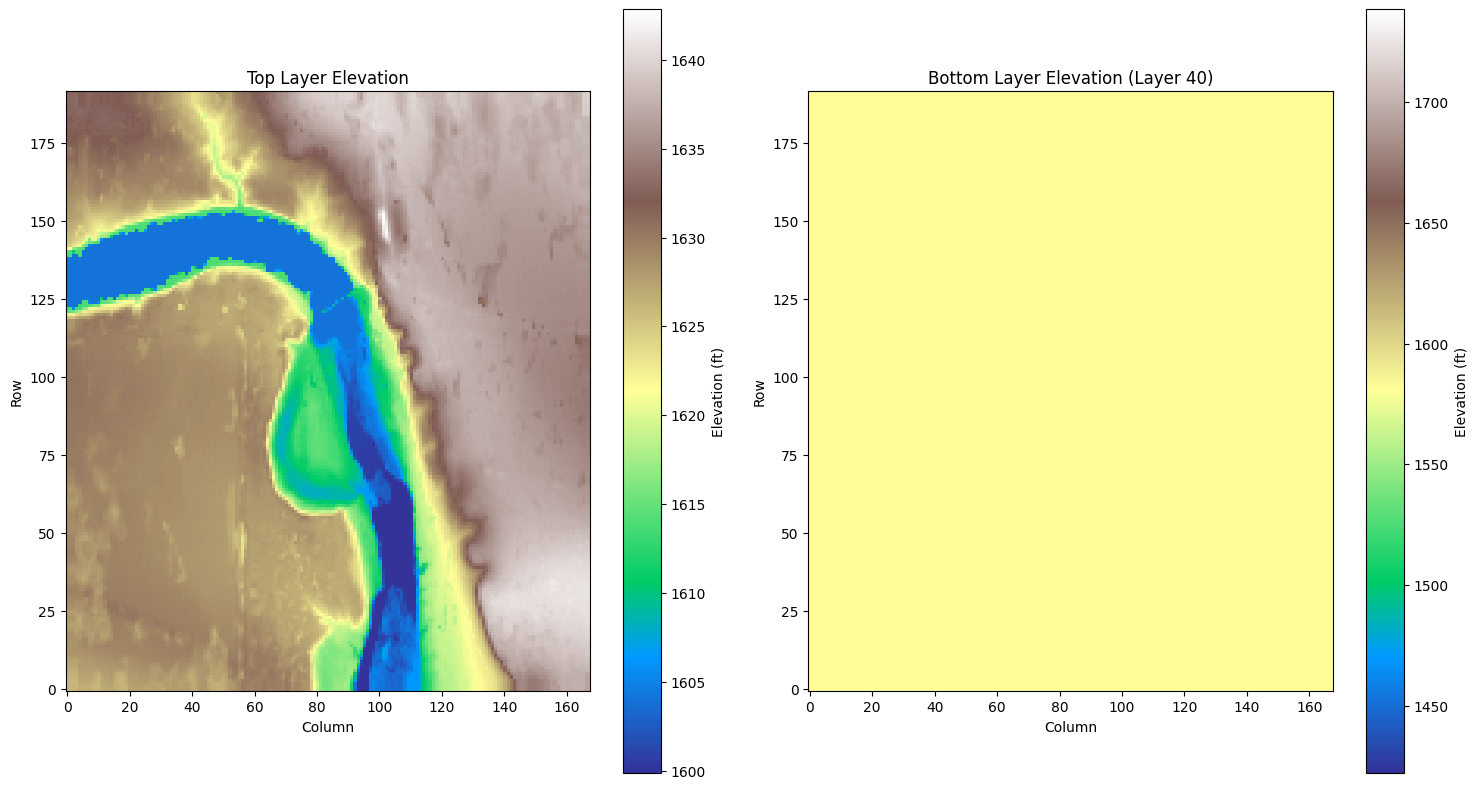

In [117]:
#------------------------------Model Grid--------------------------------#
## Plot Terrain Elevation
reprojected_terrain_elevation_raster = r"C:\Users\u4eeevmq\Documents\Python\test_12_18_2024\reprojected_terrain_raster.tif"

# Assuming `src.nodata` is the no-data value for the raster
terrain_elevation = np.ma.masked_equal(terrain_elevation, src.nodata)

# Find Bed Elevations
bed_elevation = np.min(terrain_elevation) # Bed elevation is the minimum value of the cropped surface elevation

# Calculate the extent of the raster
raster_width = src.width * transform[0]  # Width in feet
raster_height = src.height * abs(transform[4])  # Height in feet

# Determine the number of rows and columns based on the cell size
ncol = int(raster_width / cell_size_x)
nrow = int(raster_height / cell_size_y)

# Print the calculated grid dimensions
print(f'Number of columns: {ncol}')
print(f'Number of rows: {nrow}')

top = np.full((nrow, ncol), gw_mod_depth)  # feet below bed surface (depth of groundwater model)
nlay = int(top.max() / z)  # Number of groundwater layers based on default depth)

# Calculate grid cell centers
grid_x, grid_y = np.meshgrid(
    np.arange(0, ncol) * cell_size_x + (cell_size_x / 2),
    np.arange(0, nrow) * cell_size_y + (cell_size_y / 2),
)

# Convert cell centers to Points for intersection checks
grid_points = gpd.GeoDataFrame(
    {"geometry": [Point(x, y) for x, y in zip(grid_x.ravel(), grid_y.ravel())]},
    crs= hec_ras_crs,  # Replace with the actual CRS of your grid
)

# Read raster data and extract elevation values
with rasterio.open(reprojected_terrain_elevation_raster) as src:
    raster_array = src.read(1)  # Read the first band
    raster_transform = src.transform
    raster_crs = src.crs
    raster_bounds_box = box(*src.bounds)  # Create a shapely box for raster bounds
    terrain_elevation = np.ma.masked_equal(raster_array, src.nodata)  # Mask no-data values

# Create a GeoDataFrame for raster bounds
raster_bounds_gdf = gpd.GeoDataFrame(
    {"geometry": [raster_bounds_box]}, crs=hec_ras_crs
)

# Reproject grid points to match raster CRS
# Use the raster bounds to define the grid extent
minx, miny, maxx, maxy = raster_bounds_box.bounds
grid_x, grid_y = np.meshgrid(
    np.linspace(minx, maxx, ncol),
    np.linspace(miny, maxy, nrow),
)

# Recreate the grid points
grid_points = gpd.GeoDataFrame(
    {"geometry": [Point(x, y) for x, y in zip(grid_x.ravel(), grid_y.ravel())]},
    crs=raster_crs,
)

# Check intersection between grid points and raster bounds
intersecting_points = grid_points[grid_points.geometry.intersects(raster_bounds_box)]

# Debugging: Print details about the GeoDataFrames
print(f"Raster CRS: {raster_bounds_gdf.crs}")
print(f"Grid CRS: {grid_points.crs}")
print(f"Number of grid points: {len(grid_points)}")
print(f"Number of intersecting points: {len(intersecting_points)}")

# Set x and y origin
xmin, ymin, xmax, ymax = raster_bounds_box.bounds  # Extract bounding box extent
xorigin = xmin  # Set xorigin to the left-most boundary
yorigin = ymin  # Set yorigin to the bottom-most boundary

# Extract raster extent before looping
transform = raster_transform
xmin = transform.c
ymax = transform.f
xmax = xmin + (terrain_elevation.shape[1] * transform.a)
ymin = ymax + (terrain_elevation.shape[0] * transform.e)

print(f"✅ Raster Extent: X = ({xmin}, {xmax}), Y = ({ymin}, {ymax})")

# Function to interpolate NA values
def interpolate_na(terrain):
    # Get the coordinates of the non-masked values
    valid_mask = ~terrain.mask
    valid_coords = np.array(np.nonzero(valid_mask)).T
    valid_values = terrain[valid_mask]

    # Get the coordinates of the masked values
    invalid_mask = terrain.mask
    invalid_coords = np.array(np.nonzero(invalid_mask)).T

    # Interpolate the values at the masked coordinates
    interpolated_values = griddata(valid_coords, valid_values, invalid_coords, method='nearest')

    # Fill the masked values with the interpolated values
    terrain[invalid_mask] = interpolated_values

    return terrain

# Initialize the top array
top = np.full((nrow, ncol), np.nan)

# Update "top" values for each cell in the first layer based on surface elevation
for i in range(nrow):
    for grid_col in range(ncol):
        # Calculate the x, y coordinates of the cell center
        point_x = grid_x[i, grid_col]
        point_y = grid_y[i, grid_col]

        # Convert the grid cell center coordinates to raster indices
        col, row = ~raster_transform * (point_x, point_y)
        col, row = int(col), int(row)

        # Check if the indices are within raster bounds
        if 0 <= row < terrain_elevation.shape[0] and 0 <= col < terrain_elevation.shape[1]:
            elevation_value = terrain_elevation[row, col]

            # Update "top" based on the raster value
            top[i, grid_col] = elevation_value

# Interpolate any remaining NA values in the top array
top = interpolate_na(np.ma.masked_invalid(top))

## Initialize `tops` and `botm` lists
tops = [top]  # Add the top layer (surface elevation or default)
botm = []

# First layer bottom is calculated from the updated "top" values
first_layer_botm = np.full_like(top, bed_elevation)  # Subtract 0.5 ft for the first layer
botm.append(first_layer_botm)

# Create remaining layers with a constant thickness of 0.5 ft
for layer in range(1, 40):  # Layers 2 to 40
    next_layer_top = botm[-1]  # The top of the current layer is the bottom of the previous layer
    next_layer_botm = next_layer_top - z  # Subtract thickness from the top
    tops.append(next_layer_top)  # Add the top of the current layer
    botm.append(next_layer_botm)  # Add the bottom of the current layer

# Debugging: Check the top and bottom elevations for all layers
print("Top layer elevation (max, min):", tops[0].max(), botm[0].min())
for layer_idx in range(len(tops)):
    print(f"Layer {layer_idx + 1} top (max, min):", tops[layer_idx].max(), tops[layer_idx].min())
    print(f"Layer {layer_idx + 1} botm (max, min):", botm[layer_idx].max(), botm[layer_idx].min())
    
## Visualization: Plot the top and last bottom layers
fig, axs = plt.subplots(1, 2, figsize=(15, 8))

# Plot the top layer elevation
im1 = axs[0].imshow(top, cmap="terrain", interpolation="nearest", origin="lower")  # 🔹 Ensures (0,0) is bottom-left
axs[0].set_title("Top Layer Elevation")
axs[0].set_xlabel("Column")
axs[0].set_ylabel("Row")
fig.colorbar(im1, ax=axs[0], label="Elevation (ft)")

# Plot the bottom layer elevation (Layer 40)
im2 = axs[1].imshow(botm[-1], cmap="terrain", interpolation="nearest", origin="lower")  # 🔹 Ensures bottom-left
axs[1].set_title("Bottom Layer Elevation (Layer 40)")
axs[1].set_xlabel("Column")
axs[1].set_ylabel("Row")
fig.colorbar(im2, ax=axs[1], label="Elevation (ft)")

plt.tight_layout()
plt.show()

Left Boundary Start: (2407358.236295765, 10515701.162934666), Left Boundary End: (2407570.6507961783, 10515177.034472264)
Right Boundary Start: (2407065.5187525107, 10515580.276633618), Right Boundary End: (2407188.132000717, 10515108.82005953)
Upstream Start: (2407358.236295765, 10515701.162934666), Upstream End: (2407065.5187525107, 10515580.276633618)
Downstream Start: (2407570.6507961783, 10515177.034472264), Downstream End: (2407188.132000717, 10515108.82005953)
Upstream Line: LINESTRING (2407358.236295765 10515701.162934666, 2407065.5187525107 10515580.276633618)
Downstream Line: LINESTRING (2407570.6507961783 10515177.034472264, 2407188.132000717 10515108.82005953)
✅ Upstream and Downstream boundaries created successfully!


C:\Users\u4eeevmq\AppData\Local\Temp\ipykernel_37852\270459156.py:61: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


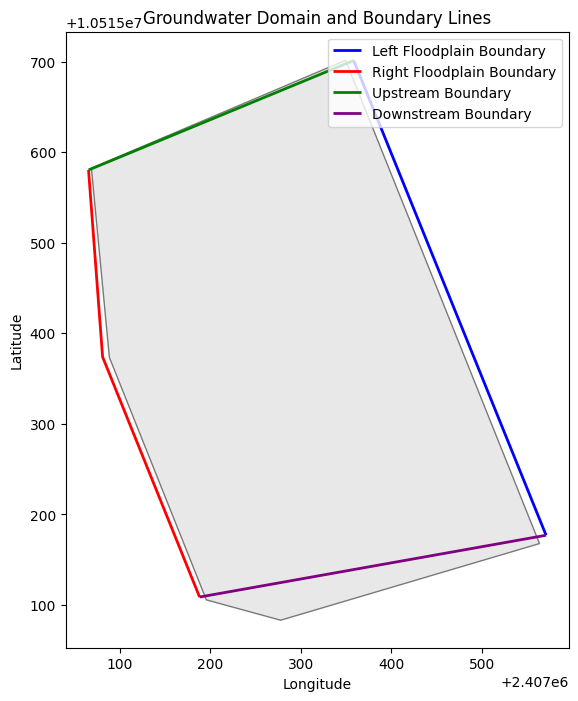

In [118]:
#---------------------------Create Boundary Conditions-----------------------------#

# Extract the first (start) and last (end) coordinates from each boundary geometry
left_start = left_boundary.geometry.iloc[0].coords[0]  # First point
left_end = left_boundary.geometry.iloc[-1].coords[-1]  # Last point

right_start = right_boundary.geometry.iloc[0].coords[0]  # First point
right_end = right_boundary.geometry.iloc[-1].coords[-1]  # Last point

# Print start and end coordinates
print(f"Left Boundary Start: {left_start}, Left Boundary End: {left_end}")
print(f"Right Boundary Start: {right_start}, Right Boundary End: {right_end}")

# Upstream boundary coordinates (use left and right start points)
upstream_start_x, upstream_start_y = left_start  # Start of upstream from left boundary
upstream_end_x, upstream_end_y = right_start  # End of upstream from right boundary

# Downstream boundary coordinates (use left and right end points)
downstream_start_x, downstream_start_y = left_end  # Start of downstream from left boundary
downstream_end_x, downstream_end_y = right_end  # End of downstream from right boundary

# Print extracted coordinates
print(f"Upstream Start: ({upstream_start_x}, {upstream_start_y}), Upstream End: ({upstream_end_x}, {upstream_end_y})")
print(f"Downstream Start: ({downstream_start_x}, {downstream_start_y}), Downstream End: ({downstream_end_x}, {downstream_end_y})")

# Use the extracted start and end points
upstream_line = LineString([(upstream_start_x, upstream_start_y), (upstream_end_x, upstream_end_y)])
downstream_line = LineString([(downstream_start_x, downstream_start_y), (downstream_end_x, downstream_end_y)])

# Convert to GeoDataFrame
upstream_boundary = gpd.GeoDataFrame(geometry=[upstream_line], crs=left_boundary.crs)
downstream_boundary = gpd.GeoDataFrame(geometry=[downstream_line], crs=left_boundary.crs)

# Print boundary lines
print(f"Upstream Line: {upstream_line}")
print(f"Downstream Line: {downstream_line}")

# Visualize Groundwater Data
# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 8))

# Plot groundwater domain
if 'ground_water_domain' in locals() and not ground_water_domain.empty:
    ground_water_domain.plot(ax=ax, color="lightgray", edgecolor="black", alpha=0.5, label="Groundwater Domain")

# Plot left and right floodplain boundaries
if 'left_boundary' in locals() and not left_boundary.empty:
    left_boundary.plot(ax=ax, color="blue", linewidth=2, label="Left Floodplain Boundary")

if 'right_boundary' in locals() and not right_boundary.empty:
    right_boundary.plot(ax=ax, color="red", linewidth=2, label="Right Floodplain Boundary")

# Plot upstream and downstream boundary lines
if 'upstream_boundary' in locals() and not upstream_boundary.empty:
    upstream_boundary.plot(ax=ax, color="green", linewidth=2, label="Upstream Boundary")

if 'downstream_boundary' in locals() and not downstream_boundary.empty:
    downstream_boundary.plot(ax=ax, color="purple", linewidth=2, label="Downstream Boundary")

# Set plot labels and title
plt.legend()
plt.title("Groundwater Domain and Boundary Lines")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# Check if boundaries were created successfully
if not upstream_boundary.empty and not downstream_boundary.empty:
    print("✅ Upstream and Downstream boundaries created successfully!")
else:
    print("❌ Error: One or both boundaries are empty. Check input data.")

✅ Total Active Cells: 63040
✅ Total Inactive Cells: 1227200


C:\Users\u4eeevmq\AppData\Local\Temp\ipykernel_37852\1128784697.py:16: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  grid_gdf["inside_domain"] = grid_gdf.geometry.intersects(ground_water_domain.unary_union)
C:\Users\u4eeevmq\AppData\Local\Temp\ipykernel_37852\1128784697.py:45: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


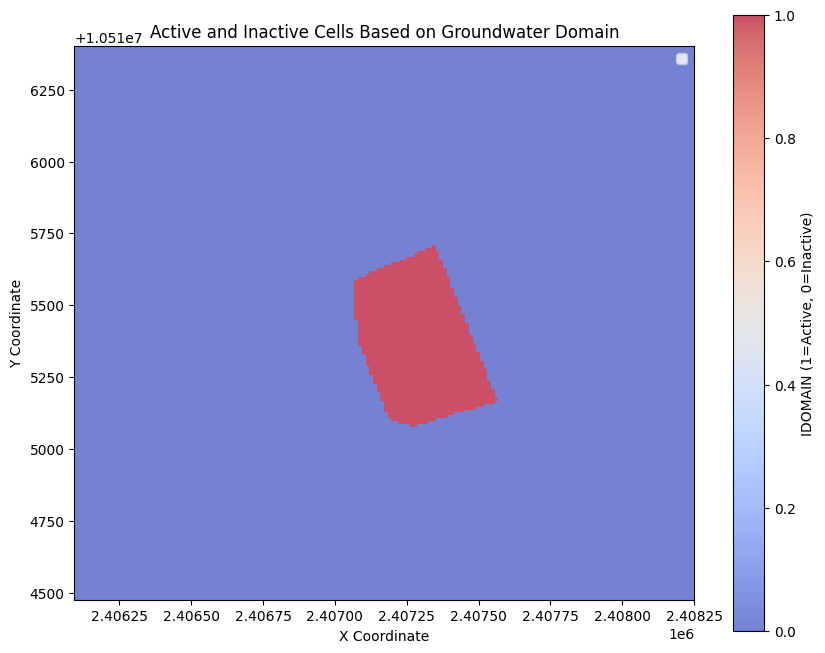

In [119]:
#---------------------------Define Active Cells-----------------------------#
# Define grid cell polygons based on grid resolution
grid_cells = []
for row in range(nrow):
    for col in range(ncol):
        x_min = grid_x[row, col] - (cell_size_x / 2)
        x_max = grid_x[row, col] + (cell_size_x / 2)
        y_min = grid_y[row, col] - (cell_size_y / 2)
        y_max = grid_y[row, col] + (cell_size_y / 2)
        grid_cells.append(Polygon([(x_min, y_min), (x_min, y_max), (x_max, y_max), (x_max, y_min)]))

# Convert to GeoDataFrame
grid_gdf = gpd.GeoDataFrame(geometry=grid_cells, crs=ground_water_domain.crs)

# -------------------- Step 3: Perform Spatial Join -------------------- #
grid_gdf["inside_domain"] = grid_gdf.geometry.intersects(ground_water_domain.unary_union)

# -------------------- Step 4: Initialize IDOMAIN -------------------- #
idomain = np.zeros((nlay, nrow, ncol), dtype=int)

# Assign active cells where grid intersects groundwater domain
for idx, inside in enumerate(grid_gdf["inside_domain"]):
    row, col = divmod(idx, ncol)  # Convert flat index to row, col
    if inside:
        idomain[:, row, col] = 1  # Mark as active

# Debugging: Print active/inactive cell count
print(f"✅ Total Active Cells: {np.sum(idomain == 1)}")
print(f"✅ Total Inactive Cells: {np.sum(idomain == 0)}")

fig, ax = plt.subplots(figsize=(10, 8))

# Plot IDOMAIN (First Layer)
im = ax.imshow(idomain[0, :, :], cmap="coolwarm", interpolation="nearest", origin="lower",
               extent=[grid_x.min(), grid_x.max(), grid_y.min(), grid_y.max()], alpha=0.7)

# Overlay Groundwater Domain
#ground_water_domain.boundary.plot(ax=ax, color="black", linewidth=2, label="Groundwater Domain")

# Axis Formatting
plt.colorbar(im, ax=ax, label="IDOMAIN (1=Active, 0=Inactive)")
plt.title("Active and Inactive Cells Based on Groundwater Domain")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.legend()
plt.show()

C:\Users\u4eeevmq\AppData\Local\Temp\ipykernel_37852\2342698109.py:2: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  grid_gdf["intersect_left_boundary"] = grid_gdf.geometry.intersects(left_boundary.unary_union)
C:\Users\u4eeevmq\AppData\Local\Temp\ipykernel_37852\2342698109.py:3: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  grid_gdf["intersect_right_boundary"] = grid_gdf.geometry.intersects(right_boundary.unary_union)
C:\Users\u4eeevmq\AppData\Local\Temp\ipykernel_37852\2342698109.py:4: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  grid_gdf["intersect_upstream_boundary"] = grid_gdf.geometry.intersects(upstream_boundary.unary_union)
C:\Users\u4eeevmq\AppData\Local\Temp\ipykernel_37852\2342698109.py:5: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  grid_gdf["inters

✅ Identified 6000 model boundary cells.


C:\Users\u4eeevmq\AppData\Local\Temp\ipykernel_37852\2342698109.py:43: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  "left": cell.geometry.distance(left_boundary.unary_union),
C:\Users\u4eeevmq\AppData\Local\Temp\ipykernel_37852\2342698109.py:44: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  "right": cell.geometry.distance(right_boundary.unary_union),
C:\Users\u4eeevmq\AppData\Local\Temp\ipykernel_37852\2342698109.py:45: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  "upstream": cell.geometry.distance(upstream_boundary.unary_union),
C:\Users\u4eeevmq\AppData\Local\Temp\ipykernel_37852\2342698109.py:46: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  "downstream": cell.geometry.distance(downstream_boundary.unary_union)
C:\Users\u4eeevmq\AppData\Local\Temp\ipykernel_

✅ Left Boundary Cells: 2000
✅ Right Boundary Cells: 1840
✅ Upstream Boundary Cells: 960
✅ Downstream Boundary Cells: 1200
✅ No duplicate entries found in combined boundary cells.
✅ Total Unique Boundary Cells: 6000
✅ Left Boundary Cells (First Layer): 50
✅ Right Boundary Cells (First Layer): 46
✅ Upstream Boundary Cells (First Layer): 24
✅ Downstream Boundary Cells (First Layer): 30


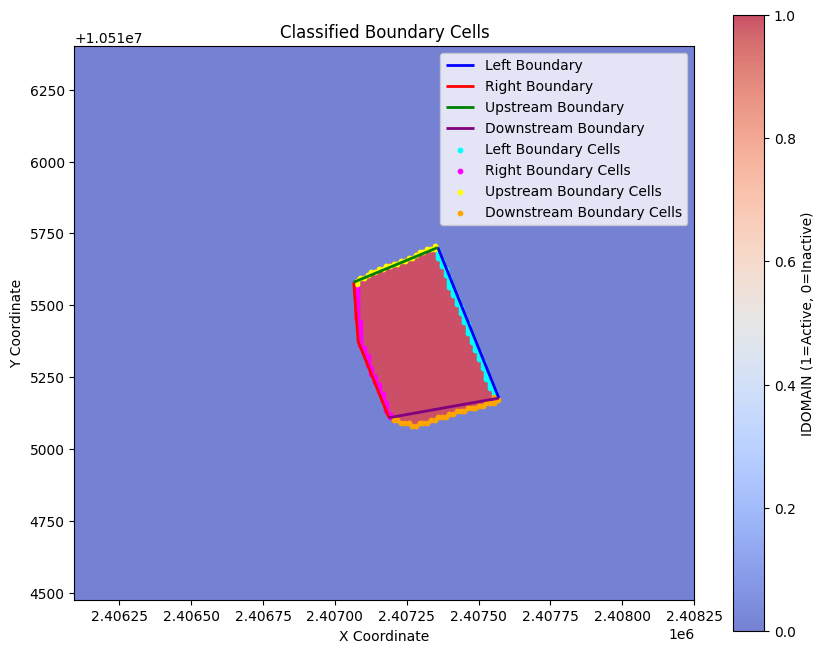

In [120]:
#---------------------------Identify Boundary Cells-----------------------------#
grid_gdf["intersect_left_boundary"] = grid_gdf.geometry.intersects(left_boundary.unary_union)
grid_gdf["intersect_right_boundary"] = grid_gdf.geometry.intersects(right_boundary.unary_union)
grid_gdf["intersect_upstream_boundary"] = grid_gdf.geometry.intersects(upstream_boundary.unary_union)
grid_gdf["intersect_downstream_boundary"] = grid_gdf.geometry.intersects(downstream_boundary.unary_union)

# Function to locate boundary cells
def identify_boundary_cells(idomain):
    boundary_cells = set()
    nlay, nrow, ncol = idomain.shape

    for row in range(nrow):
        for col in range(ncol):
            if idomain[0, row, col] == 1:
                if (
                    row > 0 and idomain[0, row - 1, col] == 0 or
                    row < nrow - 1 and idomain[0, row + 1, col] == 0 or
                    col > 0 and idomain[0, row, col - 1] == 0 or
                    col < ncol - 1 and idomain[0, row, col + 1] == 0
                ):
                    for layer in range(nlay):
                        boundary_cells.add((layer, row, col))

    print(f"✅ Identified {len(boundary_cells)} model boundary cells.")
    return list(boundary_cells)

boundary_cells = identify_boundary_cells(idomain)

# Classify boundary cells based on proximity to boundary lines
def classify_boundary_cells(boundary_cells, grid_gdf, left_boundary, right_boundary, upstream_boundary, downstream_boundary):
    classified_cells = set()
    left_boundary_cells = []
    right_boundary_cells = []
    upstream_boundary_cells = []
    downstream_boundary_cells = []

    for layer, row, col in boundary_cells:
        if (layer, row, col) in classified_cells:
            continue  # Skip already classified cells

        cell = grid_gdf.iloc[row * ncol + col]
        distances = {
            "left": cell.geometry.distance(left_boundary.unary_union),
            "right": cell.geometry.distance(right_boundary.unary_union),
            "upstream": cell.geometry.distance(upstream_boundary.unary_union),
            "downstream": cell.geometry.distance(downstream_boundary.unary_union)
        }
        closest_boundary = min(distances, key=distances.get)
        if closest_boundary == "left":
            left_boundary_cells.append((layer, row, col))
        elif closest_boundary == "right":
            right_boundary_cells.append((layer, row, col))
        elif closest_boundary == "upstream":
            upstream_boundary_cells.append((layer, row, col))
        elif closest_boundary == "downstream":
            downstream_boundary_cells.append((layer, row, col))

        classified_cells.add((layer, row, col))  # Mark cell as classified

    return left_boundary_cells, right_boundary_cells, upstream_boundary_cells, downstream_boundary_cells

left_boundary_cells, right_boundary_cells, upstream_boundary_cells, downstream_boundary_cells = classify_boundary_cells(
    boundary_cells, grid_gdf, left_boundary, right_boundary, upstream_boundary, downstream_boundary
)

# Combine all boundary cells into a single list
all_boundary_cells = left_boundary_cells + right_boundary_cells + upstream_boundary_cells + downstream_boundary_cells

# Print the number of boundary cells identified for each boundary type
print(f"✅ Left Boundary Cells: {len(left_boundary_cells)}")
print(f"✅ Right Boundary Cells: {len(right_boundary_cells)}")
print(f"✅ Upstream Boundary Cells: {len(upstream_boundary_cells)}")
print(f"✅ Downstream Boundary Cells: {len(downstream_boundary_cells)}")

# Check for duplicates in the combined boundary cells
unique_boundary_cells = set(all_boundary_cells)
if len(unique_boundary_cells) != len(all_boundary_cells):
    print(f"❌ Found {len(all_boundary_cells) - len(unique_boundary_cells)} duplicate entries in combined boundary cells.")
else:
    print("✅ No duplicate entries found in combined boundary cells.")

# Print the total number of unique boundary cells
print(f"✅ Total Unique Boundary Cells: {len(unique_boundary_cells)}")

# Print the number of cells for each boundary type in the first layer
left_boundary_cells_first_layer = [cell for cell in left_boundary_cells if cell[0] == 0]
right_boundary_cells_first_layer = [cell for cell in right_boundary_cells if cell[0] == 0]
upstream_boundary_cells_first_layer = [cell for cell in upstream_boundary_cells if cell[0] == 0]
downstream_boundary_cells_first_layer = [cell for cell in downstream_boundary_cells if cell[0] == 0]

# Should match the amount of boundary cells identified in the first layer
print(f"✅ Left Boundary Cells (First Layer): {len(left_boundary_cells_first_layer)}")
print(f"✅ Right Boundary Cells (First Layer): {len(right_boundary_cells_first_layer)}")
print(f"✅ Upstream Boundary Cells (First Layer): {len(upstream_boundary_cells_first_layer)}")
print(f"✅ Downstream Boundary Cells (First Layer): {len(downstream_boundary_cells_first_layer)}")

fig, ax = plt.subplots(figsize=(10, 8))

# Plot IDOMAIN (First Layer)
im = ax.imshow(idomain[0, :, :], cmap="coolwarm", interpolation="nearest", origin="lower",
               extent=[grid_x.min(), grid_x.max(), grid_y.min(), grid_y.max()], alpha=0.7)

# Plot Boundary Lines
left_boundary.plot(ax=ax, color="blue", linewidth=2, label="Left Boundary")
right_boundary.plot(ax=ax, color="red", linewidth=2, label="Right Boundary")
upstream_boundary.plot(ax=ax, color="green", linewidth=2, label="Upstream Boundary")
downstream_boundary.plot(ax=ax, color="purple", linewidth=2, label="Downstream Boundary")

# Plot Classified Boundary Cells
left_boundary_cells_coords = [(grid_x[row, col], grid_y[row, col]) for _, row, col in left_boundary_cells_first_layer]
right_boundary_cells_coords = [(grid_x[row, col], grid_y[row, col]) for _, row, col in right_boundary_cells_first_layer]
upstream_boundary_cells_coords = [(grid_x[row, col], grid_y[row, col]) for _, row, col in upstream_boundary_cells_first_layer]
downstream_boundary_cells_coords = [(grid_x[row, col], grid_y[row, col]) for _, row, col in downstream_boundary_cells_first_layer]

left_boundary_cells_x, left_boundary_cells_y = zip(*left_boundary_cells_coords)
right_boundary_cells_x, right_boundary_cells_y = zip(*right_boundary_cells_coords)
upstream_boundary_cells_x, upstream_boundary_cells_y = zip(*upstream_boundary_cells_coords)
downstream_boundary_cells_x, downstream_boundary_cells_y = zip(*downstream_boundary_cells_coords)

ax.scatter(left_boundary_cells_x, left_boundary_cells_y, color="cyan", label="Left Boundary Cells", s=10)
ax.scatter(right_boundary_cells_x, right_boundary_cells_y, color="magenta", label="Right Boundary Cells", s=10)
ax.scatter(upstream_boundary_cells_x, upstream_boundary_cells_y, color="yellow", label="Upstream Boundary Cells", s=10)
ax.scatter(downstream_boundary_cells_x, downstream_boundary_cells_y, color="orange", label="Downstream Boundary Cells", s=10)

# Axis Formatting
plt.colorbar(im, ax=ax, label="IDOMAIN (1=Active, 0=Inactive)")
plt.title("Classified Boundary Cells")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.legend()
plt.show()

Grid points elevation values saved as grid_points_elevation.csv
Max Elevation Upstream Boundary: 1604.76611328125
Max Elevation Downstream Boundary: 1600.780029296875


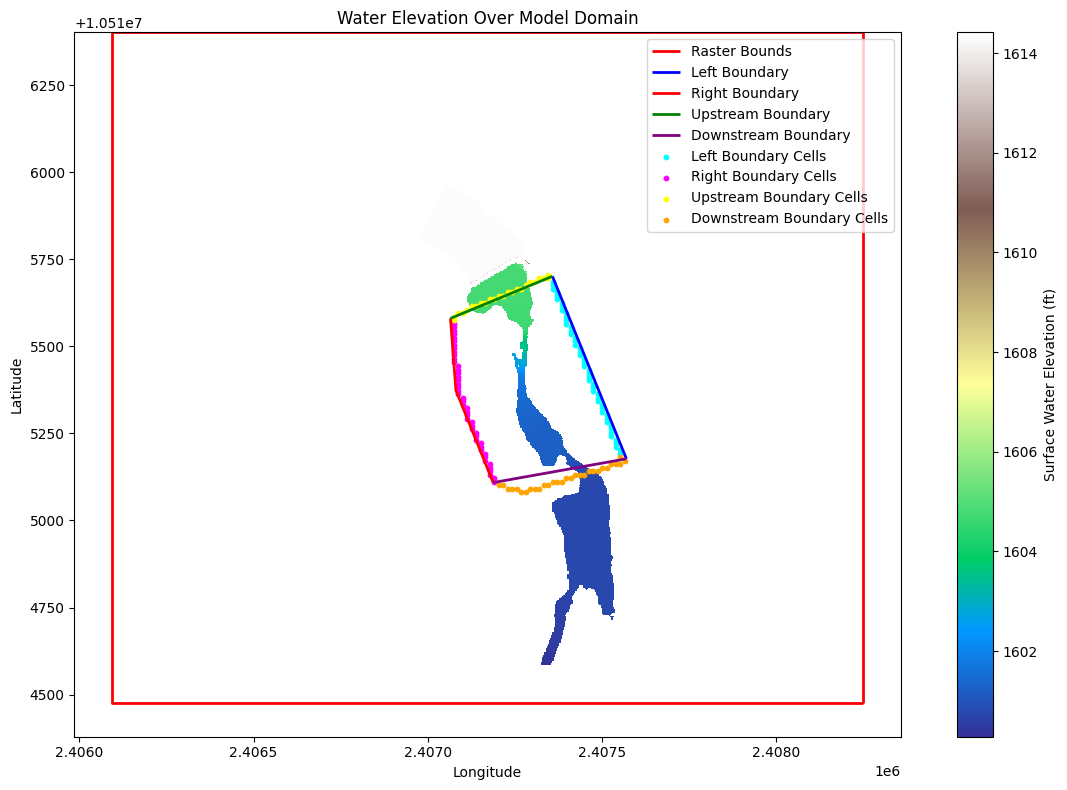

In [121]:
#----------------------Calculate Ground Water Elevation------------------------#
# Define the grid points (assuming grid_points is a GeoDataFrame with 'geometry' column)
grid_points_coords = [(point.x, point.y) for point in grid_points.geometry]

# Extract elevation values at grid points
elevation_values = []
with rasterio.open(cropped_output_raster) as src:
    for x, y in grid_points_coords:
        row, col = rowcol(src.transform, x, y)
        if 0 <= row < src.height and 0 <= col < src.width:
            elevation = src.read(1)[row, col]
            elevation_values.append(elevation)
        else:
            elevation_values.append(None)  # Append None if the point is out of bounds

# Create a DataFrame with the grid points and their corresponding elevation values
grid_points_df = pd.DataFrame({
    'x': [coord[0] for coord in grid_points_coords],
    'y': [coord[1] for coord in grid_points_coords],
    'elevation': elevation_values
})

# Save the DataFrame to a CSV file
output_csv = "grid_points_elevation.csv"
grid_points_df.to_csv(output_csv, index=False)

print(f"Grid points elevation values saved as {output_csv}")

# Read the CSV file
grid_points_df = pd.read_csv(output_csv)

# Function to get max elevation for boundary cells
def get_max_elevation(boundary_cells_coords, grid_points_df):
    elevations = []
    for x, y in boundary_cells_coords:
        elevation = grid_points_df.loc[(grid_points_df['x'] == x) & (grid_points_df['y'] == y), 'elevation'].values
        if elevation.size > 0:
            elevations.append(elevation[0])
    return max(elevations) if elevations else None

# Find matching coordinates for boundary cells
upstream_boundary_cells_coords = [(grid_x[row, col], grid_y[row, col]) for _, row, col in upstream_boundary_cells_first_layer]
downstream_boundary_cells_coords = [(grid_x[row, col], grid_y[row, col]) for _, row, col in downstream_boundary_cells_first_layer]

# Calculate max surface water elevation for upstream and downstream boundary cells
max_elevation_upstream = get_max_elevation(upstream_boundary_cells_coords, grid_points_df)
max_elevation_downstream = get_max_elevation(downstream_boundary_cells_coords, grid_points_df)

# Print max elevations
print("Max Elevation Upstream Boundary:", max_elevation_upstream)
print("Max Elevation Downstream Boundary:", max_elevation_downstream)

# Plot the raster of surface elevation over the model domain
fig, ax = plt.subplots(figsize=(12, 8))

# Plot the raster surface elevation
plt_extent = [cropped_surface_transform[2], 
              cropped_surface_transform[2] + cropped_surface_transform[0] * cropped_surface_elevation.shape[1],
              cropped_surface_transform[5] + cropped_surface_transform[4] * cropped_surface_elevation.shape[0],
              cropped_surface_transform[5]]
elevation_plot = ax.imshow(
    cropped_surface_elevation,
    extent=plt_extent,
    cmap="terrain",
    interpolation="nearest"
)

# Add the model grid points
#grid_points.plot(ax=ax, color="blue", markersize=1, label="Model Grid Points")

# Add the raster bounds for reference
raster_bounds_gdf.boundary.plot(ax=ax, color="red", linewidth=2, label="Raster Bounds")

# Add a colorbar for the raster
cbar = fig.colorbar(elevation_plot, ax=ax, label="Surface Water Elevation (ft)")

# Plot Boundary Lines
left_boundary.plot(ax=ax, color="blue", linewidth=2, label="Left Boundary")
right_boundary.plot(ax=ax, color="red", linewidth=2, label="Right Boundary")
upstream_boundary.plot(ax=ax, color="green", linewidth=2, label="Upstream Boundary")
downstream_boundary.plot(ax=ax, color="purple", linewidth=2, label="Downstream Boundary")

# Plot Classified Boundary Cells
left_boundary_cells_coords = [(grid_x[row, col], grid_y[row, col]) for _, row, col in left_boundary_cells_first_layer]
right_boundary_cells_coords = [(grid_x[row, col], grid_y[row, col]) for _, row, col in right_boundary_cells_first_layer]
upstream_boundary_cells_coords = [(grid_x[row, col], grid_y[row, col]) for _, row, col in upstream_boundary_cells_first_layer]
downstream_boundary_cells_coords = [(grid_x[row, col], grid_y[row, col]) for _, row, col in downstream_boundary_cells_first_layer]

left_boundary_cells_x, left_boundary_cells_y = zip(*left_boundary_cells_coords)
right_boundary_cells_x, right_boundary_cells_y = zip(*right_boundary_cells_coords)
upstream_boundary_cells_x, upstream_boundary_cells_y = zip(*upstream_boundary_cells_coords)
downstream_boundary_cells_x, downstream_boundary_cells_y = zip(*downstream_boundary_cells_coords)

ax.scatter(left_boundary_cells_x, left_boundary_cells_y, color="cyan", label="Left Boundary Cells", s=10)
ax.scatter(right_boundary_cells_x, right_boundary_cells_y, color="magenta", label="Right Boundary Cells", s=10)
ax.scatter(upstream_boundary_cells_x, upstream_boundary_cells_y, color="yellow", label="Upstream Boundary Cells", s=10)
ax.scatter(downstream_boundary_cells_x, downstream_boundary_cells_y, color="orange", label="Downstream Boundary Cells", s=10)

# Customize the plot
ax.set_title("Water Elevation Over Model Domain")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.legend()
plt.tight_layout()
plt.show()

Left Boundary Groundwater Elevation First: 1605.26611328125
Left Boundary Groundwater Elevation Last: 1601.280029296875
Right Boundary Groundwater Elevation First: 1605.26611328125
Right Boundary Groundwater Elevation Last: 1601.280029296875
Upstream Boundary Groundwater Elevation First: 1605.26611328125
Upstream Boundary Groundwater Elevation Last: 1605.26611328125
Downstream Boundary Groundwater Elevation First: 1601.280029296875
Downstream Boundary Groundwater Elevation Last: 1601.280029296875
Left Boundary Groundwater Elevations: [np.float64(1605.26611328125), np.float64(1605.2641192422384), np.float64(1605.2621252032266), np.float64(1605.260131164215), np.float64(1605.2581371252031), np.float64(1605.2561430861915), np.float64(1605.25414904718), np.float64(1605.252155008168), np.float64(1605.2501609691565), np.float64(1605.2481669301449), np.float64(1605.246172891133), np.float64(1605.2441788521214), np.float64(1605.2421848131096), np.float64(1605.240190774098), np.float64(1605.238

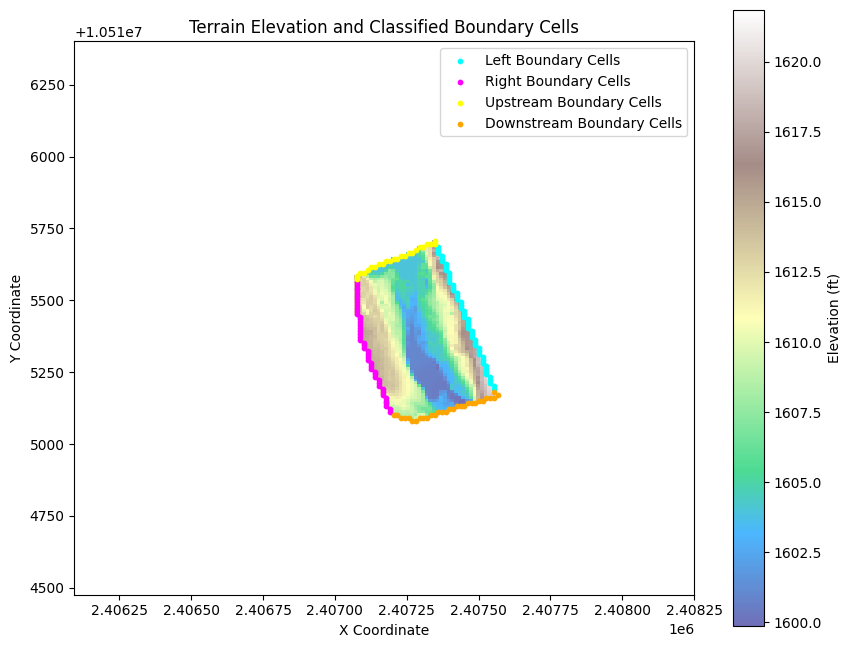

In [122]:
#----------------------Assign Ground Water Elevation to Boundary Conditions------------------------#
# Assign Ground Water Elevation to Boundary Cells
def calculate_gw_elevation(boundary_cells, top_elevation, offset):
    gw_elevation_min = []
    for cell in boundary_cells:
        layer, row, col = cell
        gw_elevation = top_elevation + offset  # Simply add the offset to the scalar top_elevation
        gw_elevation_min.append(gw_elevation)
    return gw_elevation_min

# Identify first and last cell for each boundary
def get_boundary_first_last(boundary_cells):
    if not boundary_cells:
        return None, None
    return boundary_cells[0], boundary_cells[-1]

left_boundary_first, left_boundary_last = get_boundary_first_last(left_boundary_cells_first_layer)
right_boundary_first, right_boundary_last = get_boundary_first_last(right_boundary_cells_first_layer)
upstream_boundary_first, upstream_boundary_last = get_boundary_first_last(upstream_boundary_cells_first_layer)
downstream_boundary_first, downstream_boundary_last = get_boundary_first_last(downstream_boundary_cells_first_layer)

# Calculate groundwater elevations for each boundary
gw_elevation_left_first = calculate_gw_elevation([left_boundary_first], max_elevation_upstream, gw_offset)[0]
gw_elevation_left_last = calculate_gw_elevation([left_boundary_last], max_elevation_downstream, gw_offset)[0]

gw_elevation_right_first = calculate_gw_elevation([right_boundary_first], max_elevation_upstream, gw_offset)[0]
gw_elevation_right_last = calculate_gw_elevation([right_boundary_last], max_elevation_downstream, gw_offset)[0]

gw_elevation_upstream_first = calculate_gw_elevation([upstream_boundary_first], max_elevation_upstream, gw_offset)[0]
gw_elevation_upstream_last = calculate_gw_elevation([upstream_boundary_last], max_elevation_upstream, gw_offset)[0]

gw_elevation_downstream_first = calculate_gw_elevation([downstream_boundary_first], max_elevation_downstream, gw_offset)[0]
gw_elevation_downstream_last = calculate_gw_elevation([downstream_boundary_last], max_elevation_downstream, gw_offset)[0]

# Debugging: Print the calculated groundwater elevations
print("Left Boundary Groundwater Elevation First:", gw_elevation_left_first)
print("Left Boundary Groundwater Elevation Last:", gw_elevation_left_last)
print("Right Boundary Groundwater Elevation First:", gw_elevation_right_first)
print("Right Boundary Groundwater Elevation Last:", gw_elevation_right_last)
print("Upstream Boundary Groundwater Elevation First:", gw_elevation_upstream_first)
print("Upstream Boundary Groundwater Elevation Last:", gw_elevation_upstream_last)
print("Downstream Boundary Groundwater Elevation First:", gw_elevation_downstream_first)
print("Downstream Boundary Groundwater Elevation Last:", gw_elevation_downstream_last)

# Interpolate Groundwater Elevation Across Boundary Cells
def interpolate_gw_elevation(boundary_cells, gw_elevation_first, gw_elevation_last):
    n = len(boundary_cells)
    if n <= 1:
        return [gw_elevation_first] * n
    interpolated_gw_elevations = []
    for i in range(n):
        interpolated_value = gw_elevation_first + (gw_elevation_last - gw_elevation_first) * i / (n - 1)
        interpolated_gw_elevations.append(interpolated_value)
    return interpolated_gw_elevations

# Interpolate groundwater elevations for each boundary
gw_elevation_left = interpolate_gw_elevation(left_boundary_cells, gw_elevation_left_first, gw_elevation_left_last)
gw_elevation_right = interpolate_gw_elevation(right_boundary_cells, gw_elevation_right_first, gw_elevation_right_last)
gw_elevation_upstream = interpolate_gw_elevation(upstream_boundary_cells, gw_elevation_upstream_first, gw_elevation_upstream_last)
gw_elevation_downstream = interpolate_gw_elevation(downstream_boundary_cells, gw_elevation_downstream_first, gw_elevation_downstream_last)

# Debugging: Print the interpolated groundwater elevations
print("Left Boundary Groundwater Elevations:", gw_elevation_left)
print("Right Boundary Groundwater Elevations:", gw_elevation_right)
print("Upstream Boundary Groundwater Elevations:", gw_elevation_upstream)
print("Downstream Boundary Groundwater Elevations:", gw_elevation_downstream)

# Plot the groundwater elevation in only the active cells and highlight the boundary cells
fig, ax = plt.subplots(figsize=(10, 8))

# Plot elevation for active cells
active_cells = np.where(idomain[0, :, :] == 1)
top_active = np.ma.masked_where(idomain[0, :, :] == 0, top)
im = ax.imshow(top_active, cmap="terrain", interpolation="nearest", origin="lower",
               extent=[grid_x.min(), grid_x.max(), grid_y.min(), grid_y.max()], alpha=0.7)

# Plot Classified Boundary Cells
left_boundary_cells_coords = [(grid_x[row, col], grid_y[row, col]) for _, row, col in left_boundary_cells_first_layer]
right_boundary_cells_coords = [(grid_x[row, col], grid_y[row, col]) for _, row, col in right_boundary_cells_first_layer]
upstream_boundary_cells_coords = [(grid_x[row, col], grid_y[row, col]) for _, row, col in upstream_boundary_cells_first_layer]
downstream_boundary_cells_coords = [(grid_x[row, col], grid_y[row, col]) for _, row, col in downstream_boundary_cells_first_layer]

left_boundary_cells_x, left_boundary_cells_y = zip(*left_boundary_cells_coords)
right_boundary_cells_x, right_boundary_cells_y = zip(*right_boundary_cells_coords)
upstream_boundary_cells_x, upstream_boundary_cells_y = zip(*upstream_boundary_cells_coords)
downstream_boundary_cells_x, downstream_boundary_cells_y = zip(*downstream_boundary_cells_coords)

ax.scatter(left_boundary_cells_x, left_boundary_cells_y, color="cyan", label="Left Boundary Cells", s=10)
ax.scatter(right_boundary_cells_x, right_boundary_cells_y, color="magenta", label="Right Boundary Cells", s=10)
ax.scatter(upstream_boundary_cells_x, upstream_boundary_cells_y, color="yellow", label="Upstream Boundary Cells", s=10)
ax.scatter(downstream_boundary_cells_x, downstream_boundary_cells_y, color="orange", label="Downstream Boundary Cells", s=10)

# Axis Formatting
plt.colorbar(im, ax=ax, label="Elevation (ft)")
plt.title("Terrain Elevation and Classified Boundary Cells")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.legend()
plt.show()

In [123]:
#----------------------Create Constant Head Data------------------------#
# Create the CHD package
chd_data = []

# Identify boundary cells 
ch_left_boundary = gw_elevation_left  # Groundwater elevation list matching the left boundary cells (nlay, nrow, ncol)
ch_right_boundary = gw_elevation_right  # Groundwater elevation list matching the right boundary cells (nlay, nrow, ncol)
ch_upstream_boundary = gw_elevation_upstream  # Groundwater elevation list matching the upstream boundary cells (nlay, nrow, ncol)
ch_downstream_boundary = gw_elevation_downstream  # Groundwater elevation list matching the downstream boundary cells (nlay, nrow, ncol)

# Set to keep track of unique (nlay, nrow, ncol) coordinates
unique_chd_cells = set()
duplicate_chd_cells = set()

# Add boundary conditions for each side of the model and track duplicates

# Left Boundaries (Constant Head = ch_left_boundary)
for i, cell in enumerate(left_boundary_cells):
    nlay, nrow, ncol = cell[0], cell[1], cell[2]  # Extract nlay, nrow, ncol
    if (nlay, nrow, ncol) not in unique_chd_cells:
        chd_data.append([nlay, nrow, ncol, ch_left_boundary[i]])
        unique_chd_cells.add((nlay, nrow, ncol))  # Add to unique set
    else:
        duplicate_chd_cells.add((nlay, nrow, ncol))  # Track duplicate cells

# Right Boundaries (Constant Head = ch_right_boundary)
for i, cell in enumerate(right_boundary_cells):
    nlay, nrow, ncol = cell[0], cell[1], cell[2]  # Extract nlay, nrow, ncol
    if (nlay, nrow, ncol) not in unique_chd_cells:
        chd_data.append([nlay, nrow, ncol, ch_right_boundary[i]])
        unique_chd_cells.add((nlay, nrow, ncol))  # Add to unique set
    else:
        duplicate_chd_cells.add((nlay, nrow, ncol))  # Track duplicate cells

# Upstream Boundary (Constant Head = ch_upstream_boundary)
for i, cell in enumerate(upstream_boundary_cells):
    nlay, nrow, ncol = cell[0], cell[1], cell[2]  # Extract nlay, nrow, ncol
    if (nlay, nrow, ncol) not in unique_chd_cells:
        chd_data.append([nlay, nrow, ncol, ch_upstream_boundary[i]])
        unique_chd_cells.add((nlay, nrow, ncol))  # Add to unique set
    else:
        duplicate_chd_cells.add((nlay, nrow, ncol))  # Track duplicate cells

# Downstream Boundary (Constant Head = ch_downstream_boundary)
for i, cell in enumerate(downstream_boundary_cells):
    nlay, nrow, ncol = cell[0], cell[1], cell[2]  # Extract nlay, nrow, ncol
    if (nlay, nrow, ncol) not in unique_chd_cells:
        chd_data.append([nlay, nrow, ncol, ch_downstream_boundary[i]])
        unique_chd_cells.add((nlay, nrow, ncol))  # Add to unique set
    else:
        duplicate_chd_cells.add((nlay, nrow, ncol))  # Track duplicate cells

print(f"✅ Total Unique CHD Boundary Cells: {len(unique_chd_cells)}")
print(f"❌ Total Duplicate CHD Boundary Cells: {len(duplicate_chd_cells)}")

# Convert np.float32 to standard Python float
chd_data_converted = []

for item in chd_data:
    # Check if item[3] is a list and convert each element to float
    if isinstance(item[3], list):
        converted_head_value = [float(val) for val in item[3]]
    else:
        converted_head_value = float(item[3])
    
    converted_item = [item[0], item[1], item[2], converted_head_value]
    chd_data_converted.append(converted_item)

print(f"✅ Assigned {len(chd_data_converted)} CHD boundary cells.")

# Optional: print the boundary cell counts
print(f"Left Boundary Cells: {len(left_boundary_cells)}")
print(f"Right Boundary Cells: {len(right_boundary_cells)}")
print(f"Upstream Boundary Cells: {len(upstream_boundary_cells)}")
print(f"Downstream Boundary Cells: {len(downstream_boundary_cells)}")

✅ Total Unique CHD Boundary Cells: 6000
❌ Total Duplicate CHD Boundary Cells: 0
✅ Assigned 6000 CHD boundary cells.
Left Boundary Cells: 2000
Right Boundary Cells: 1840
Upstream Boundary Cells: 960
Downstream Boundary Cells: 1200


                           geometry   pump_rate
0  POINT (2407139.209 10515264.417) -393.811729
1  POINT (2407455.369 10515250.752) -152.758829
2  POINT (2407247.192 10515379.448) -397.706717
Random wells shapefile saved as random_wells.shp
    pump_rate                          geometry
0 -393.811729  POINT (2407139.209 10515264.417)
1 -152.758829  POINT (2407455.369 10515250.752)
2 -397.706717  POINT (2407247.192 10515379.448)
Well Locations:
0    POINT (2407139.209 10515264.417)
1    POINT (2407455.369 10515250.752)
2    POINT (2407247.192 10515379.448)
Name: geometry, dtype: geometry
Pumping Rates:
0   -393.811729
1   -152.758829
2   -397.706717
Name: pump_rate, dtype: float64
Well Locations:
0    POINT (2407139.209 10515264.417)
1    POINT (2407455.369 10515250.752)
2    POINT (2407247.192 10515379.448)
Name: geometry, dtype: geometry
Pumping Rates:
0   -393.811729
1   -152.758829
2   -397.706717
Name: pump_rate, dtype: float64


C:\Users\u4eeevmq\AppData\Roaming\Python\Python311\site-packages\pyogrio\geopandas.py:662: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  write(


[0, 78, 81, -393.81172943107424]
[0, 90, 89, -397.70671745561754]
Monitoring Well at Layer 0, Row 78, Column 81 with Pumping Rate -393.81172943107424 cubic feet per day
Monitoring Well at Layer 0, Row 90, Column 89 with Pumping Rate -397.70671745561754 cubic feet per day


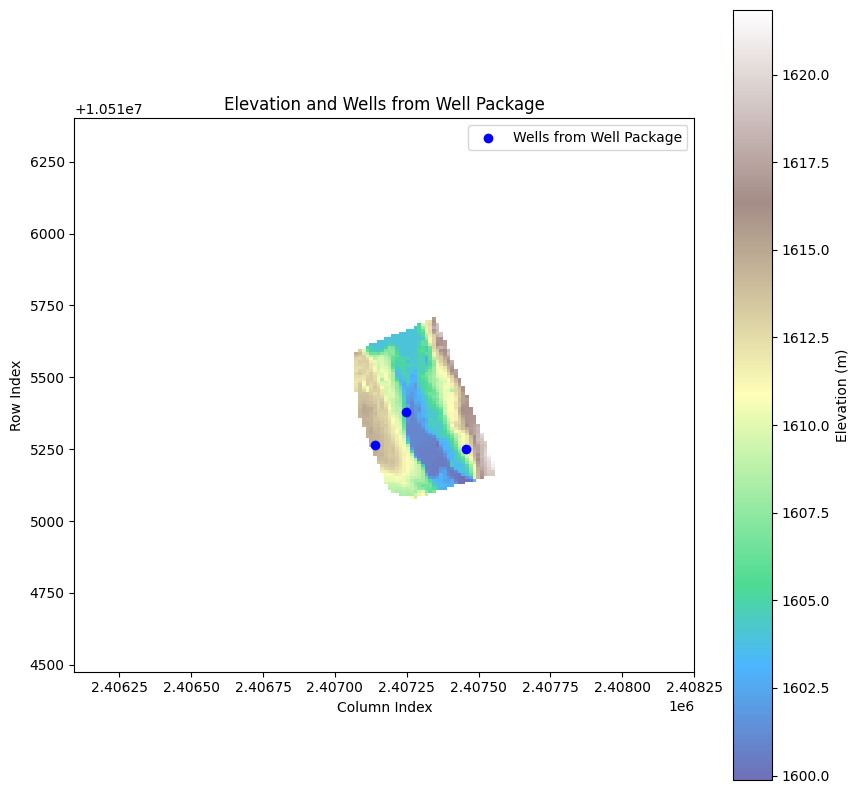

In [124]:
#----------------------Define Any Wells ------------------------#
# Get the bounds of the shapefile
minx, miny, maxx, maxy = ground_water_domain.total_bounds

# Function to generate a random point within the bounds
def generate_random_point_within(bounds):
    minx, miny, maxx, maxy = bounds
    while True:
        pnt = Point(random.uniform(minx, maxx), random.uniform(miny, maxy))
        if ground_water_domain.contains(pnt).any():
            return pnt

# Generate 3 random points within the shapefile
random_points = [generate_random_point_within((minx, miny, maxx, maxy)) for _ in range(3)]

# Assign pseudo pumping rates to these points
pumping_rates = np.random.uniform(-500, -100, 3)  # Example pseudo pumping rates

# Create a GeoDataFrame with the well locations and pumping rates
well_data = [{'geometry': point, 'pump_rate': rate} for point, rate in zip(random_points, pumping_rates)]
gdf = gpd.GeoDataFrame(well_data)

# Print the GeoDataFrame
print(gdf)

# Save the GeoDataFrame as a shapefile
output_shapefile = 'random_wells.shp'
gdf.to_file(output_shapefile)

print(f"Random wells shapefile saved as {output_shapefile}")

## Read in Actual Point Shapefile (coordinates of wells + well pumping rates)
# Define the path to your point file
## Read in Actual Point Shapefile (coordinates of wells + well pumping rates)
# Define the path to your point file
point_file_path = 'random_wells.shp'  # Replace with the actual path to your point file

# Read the point file using geopandas
gdf = gpd.read_file(point_file_path)

# Reproject the point file to the target CRS
gdf = gdf.to_crs(hec_ras_crs)

# Print the GeoDataFrame
print(gdf)

# Extract well locations and pumping rates
well_locations = gdf['geometry']
pumping_rates = gdf['pump_rate']

# Print well locations and pumping rates
print("Well Locations:")
print(well_locations)
print("Pumping Rates:")
print(pumping_rates)

# Print well locations and pumping rates
print("Well Locations:")
print(well_locations)
print("Pumping Rates:")
print(pumping_rates)

# Define the transform for converting coordinates to model grid indices
# Replace with your actual transform
transform = rasterio.transform.from_origin(xorigin, yorigin, cell_size_x, cell_size_y)

# Create the well package data
wel_data = []
nrow, ncol = idomain.shape[1], idomain.shape[2]

for idx, row in gdf.iterrows():
    well_geometry = row.geometry
    x, y = well_geometry.x, well_geometry.y
    i, j = ~transform * (x, y)  # Convert coordinates to model grid indices
    i, j = abs(int(i)), abs(int(j))  # Ensure indices are integers
    k = 0  # Assuming wells are in the first layer
    q = row['pump_rate']  # Pull the pumping rate from the point file attribute

    # Check if the well point intersects any cell in the grid
    for grid_row in range(nrow):
        for grid_col in range(ncol):
            cell_geometry = grid_gdf.iloc[grid_row * ncol + grid_col].geometry
            if well_geometry.intersects(cell_geometry):
                wel_data.append([k, grid_row, grid_col, float(q)])
                break  # Exit the loop once the intersecting cell is found

# Print the well package data for verification
for entry in wel_data:
    print(entry)

# Monitoring strategy
def monitor_wells(wel_data):
    # Example monitoring strategy: Print well locations and pumping rates
    for well in wel_data:
        k, i, j, q = well
        print(f"Monitoring Well at Layer {k}, Row {i}, Column {j} with Pumping Rate {q} cubic feet per day")

# Implement monitoring strategy
monitor_wells(wel_data)


# Plot the model grid and well locations
# Plot elevation for active cells again with the wells from the well package
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the elevation data for active cells
im = ax.imshow(top_active, cmap="terrain", interpolation="nearest", origin="lower",
               extent=[grid_x.min(), grid_x.max(), grid_y.min(), grid_y.max()], alpha=0.7)

# Add a colorbar
plt.colorbar(im, ax=ax, label='Elevation (m)')

# Overlay the wells from the well package
# Extract x and y coordinates of the wells
well_x = [row.geometry.x for idx, row in gdf.iterrows()]
well_y = [row.geometry.y for idx, row in gdf.iterrows()]

# Overlay the wells
ax.scatter(well_x, well_y, c='blue', label='Wells from Well Package')

# Add labels and legend
ax.set_xlabel('Column Index')
ax.set_ylabel('Row Index')
ax.set_title('Elevation and Wells from Well Package')
ax.legend()

# Show the plot
plt.show()

[np.float64(1604.76611328125), np.float64(1604.764404296875), np.float64(1604.7659912109375), np.float64(1604.7655029296875), np.float64(1604.76171875)]
[0, 109, 76, 1604.0, 100000.0, 1600.0, 6, -1]
[0, 109, 76, 1604.0, 100000.0, 1600.0, 6, -1]
[0, 109, 76, 1604.0, 100000.0, 1600.0, 6, -1]
[0, 109, 76, 1604.0, 100000.0, 1600.0, 6, -1]
[0, 109, 76, 1604.0, 100000.0, 1600.0, 6, -1]
[0, 120, 94, 1604.0, 100000.0, 1600.0, 6, -1]
[0, 120, 94, 1604.0, 100000.0, 1600.0, 6, -1]
[0, 120, 94, 1604.0, 100000.0, 1600.0, 6, -1]
[0, 120, 94, 1604.0, 100000.0, 1600.0, 6, -1]
[0, 120, 94, 1604.0, 100000.0, 1600.0, 6, -1]
[0, 116, 87, 1604.0, 100000.0, 1600.0, 6, -1]
[0, 116, 87, 1604.0, 100000.0, 1600.0, 6, -1]
[0, 116, 87, 1604.0, 100000.0, 1600.0, 6, -1]
[0, 116, 87, 1604.0, 100000.0, 1600.0, 6, -1]
[0, 116, 87, 1604.0, 100000.0, 1600.0, 6, -1]
[0, 117, 88, 1604.0, 100000.0, 1600.0, 6, -1]
[0, 117, 88, 1604.0, 100000.0, 1600.0, 6, -1]
[0, 117, 88, 1604.0, 100000.0, 1600.0, 6, -1]
[0, 117, 88, 1604.0

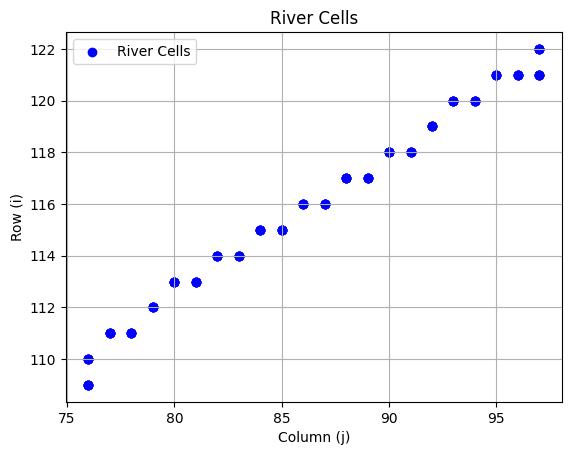

In [125]:
#----------------------Define Any River Cells ------------------------#
# Define river parameters
riv_z = int(bed_elevation) + 1   # River bed elevation in feet (example value, adjust as needed) Plus one to account for rounding error

# Remove rows where elevation is -9999
grid_points_df = grid_points_df[grid_points_df['elevation'] != -9999]

# Assign Surface Water Elevation to Upstream Boundary Cells
def calculate_river_stage(boundary_cells_coords, grid_points_df):
    elevations = []
    for x, y in boundary_cells_coords:
        elevation = grid_points_df.loc[(grid_points_df['x'] == x) & (grid_points_df['y'] == y), 'elevation'].values
        if elevation.size > 0:
            elevations.append(elevation[0])
    return elevations if elevations else None

test = calculate_river_stage(upstream_boundary_cells_coords, grid_points_df)
print(test)

# upstream Boundary cells and surface elevations
##print(max_elevation_upstream) # water surface elevations at upstream boundary cells (q)
#print(upstream_boundary_cells_first_layer) # upstream boundary cells (k, i, j)

# Create the river package data
rd = []
for k, i, j in upstream_boundary_cells_first_layer:
    for b in test:
        riv_h = int(b)  # River stage in feet (example value, adjust as needed)
        rd.append([k, i, j, float(round(riv_h)), float(round(riv_c)), float(round(riv_z)), riv_iface, riv_iflowface])


# Print the river package data for verification
for entry in rd:
    print(entry)

# Monitoring strategy
def monitor_riv_cells(rd):
    # Example monitoring strategy: Print river locations and heights
    for river in rd:
        k, i, j, q, r, s, t, u = river
        print(f"Monitoring River at Layer {k}, Row {i}, Column {j} with Height {q} in ft, Conductance {r} in ft^2/d, and Bed Elevation {s} in ft")

# Implement monitoring strategy
monitor_riv_cells(rd)

# Count the number of river cells
num_river_cells = len(rd)
print(f"Number of river cells: {num_river_cells}")

# Plot the river cells
def plot_river_cells(rd):
    x = [cell[2] for cell in rd]  # Column (j)
    y = [cell[1] for cell in rd]  # Row (i)
    plt.scatter(x, y, c='blue', marker='o', label='River Cells')
    plt.xlabel('Column (j)')
    plt.ylabel('Row (i)')
    plt.title('River Cells')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_river_cells(rd)

In [126]:
#----------------------Define particle Release Configurations------------------------#
# Initialize an empty list to store particle data
particle_data = []

# Get the unique rows and layers from the upstream_boundary_cells
unique_rows = set(cell[1] for cell in upstream_boundary_cells)
unique_layers = set(cell[0] for cell in upstream_boundary_cells if cell[0] >= 2)

# Iterate through the unique rows and layers and add 1 random particle per row and layer
for k in unique_layers:
    for i in unique_rows:
        
        # Filter the cells to get the columns for the current row and layer
        columns = [cell[2] for cell in upstream_boundary_cells if cell[0] == k and cell[1] == i]
        if columns:
            
            # Select a random column
            j = random.choice(columns)
            
            # Add particle location
            particle_data.append((k, i, j))
            

print("Particle Data:")
print(particle_data)

# Define particle release configurations using flopy
mp7_particle_data_1a = flopy.modpath.ParticleData(
    particle_data,
    drape=0,
    structured=True,
    particleids=[i for i in range(len(particle_data))],
    localz=0.5,  # Release particles at the center of the cell in the z-direction
)

# Print the particle data for verification
print(mp7_particle_data_1a)

# Define particle release configurations using flopy
mp7_particle_data_1b = flopy.modpath.LRCParticleData(
    subdivisiondata=[
        flopy.modpath.FaceDataType(
            drape=0,
            verticaldivisions1=0,
            horizontaldivisions1=0,
            verticaldivisions2=0,
            horizontaldivisions2=0,
            verticaldivisions3=0,
            horizontaldivisions3=0,
            verticaldivisions4=0,
            horizontaldivisions4=0,
            rowdivisions5=0,
            columndivisions5=0,
            rowdivisions6=3,
            columndivisions6=3,
        )
    ],
    lrcregions=[[[2, 110, 76, 0, nrow - 1, ncol - 1]]],
)

# Print the particle data for verification
print(mp7_particle_data_1b)

Particle Data:
[(2, 109, 76), (2, 110, 76), (2, 111, 77), (2, 112, 79), (2, 113, 80), (2, 114, 83), (2, 115, 85), (2, 116, 86), (2, 117, 89), (2, 118, 90), (2, 119, 92), (2, 120, 94), (2, 121, 96), (2, 122, 97), (3, 109, 76), (3, 110, 76), (3, 111, 78), (3, 112, 79), (3, 113, 81), (3, 114, 83), (3, 115, 85), (3, 116, 86), (3, 117, 89), (3, 118, 90), (3, 119, 92), (3, 120, 94), (3, 121, 97), (3, 122, 97), (4, 109, 76), (4, 110, 76), (4, 111, 77), (4, 112, 79), (4, 113, 80), (4, 114, 82), (4, 115, 84), (4, 116, 86), (4, 117, 88), (4, 118, 91), (4, 119, 92), (4, 120, 93), (4, 121, 97), (4, 122, 97), (5, 109, 76), (5, 110, 76), (5, 111, 77), (5, 112, 79), (5, 113, 80), (5, 114, 83), (5, 115, 85), (5, 116, 87), (5, 117, 89), (5, 118, 91), (5, 119, 92), (5, 120, 94), (5, 121, 97), (5, 122, 97), (6, 109, 76), (6, 110, 76), (6, 111, 78), (6, 112, 79), (6, 113, 80), (6, 114, 83), (6, 115, 85), (6, 116, 86), (6, 117, 89), (6, 118, 91), (6, 119, 92), (6, 120, 94), (6, 121, 97), (6, 122, 97), (7, 

In [127]:
#----------------------Create Any Nodes ------------------------#
# Get well and river cell numbers
nodes = {}

# Well location (k, i, j) where k is the layer, i is the row, and j is the column
nodes["well"] = []
for well in wel_data:
    k, i, j, q = well
    # Calculate the cell number for the well
    # Cell number is calculated as: ncol * (nrow * k + i) + j
    cell_number = ncol * (nrow * k + i) + j
    nodes["well"].append(cell_number)

# Print the calculated cell numbers for verification
print("Well cell numbers:", nodes["well"])

nodes["river"] = []
for rivspec in rd:
    k, i, j, q, r, s, t, u = rivspec  # Unpack all six elements
    node = ncol * (nrow * k + i) + j
    nodes["river"].append(node)

# Print the calculated cell numbers for verification
print("River cell numbers:", nodes["river"])

Well cell numbers: [13185, 15209]
River cell numbers: [18388, 18388, 18388, 18388, 18388, 20254, 20254, 20254, 20254, 20254, 19575, 19575, 19575, 19575, 19575, 19744, 19744, 19744, 19744, 19744, 18556, 18556, 18556, 18556, 18556, 19065, 19065, 19065, 19065, 19065, 18725, 18725, 18725, 18725, 18725, 20424, 20424, 20424, 20424, 20424, 19234, 19234, 19234, 19234, 19234, 19745, 19745, 19745, 19745, 19745, 19405, 19405, 19405, 19405, 19405, 19064, 19064, 19064, 19064, 19064, 18726, 18726, 18726, 18726, 18726, 20423, 20423, 20423, 20423, 20423, 20425, 20425, 20425, 20425, 20425, 19235, 19235, 19235, 19235, 19235, 18895, 18895, 18895, 18895, 18895, 19404, 19404, 19404, 19404, 19404, 19915, 19915, 19915, 19915, 19915, 20084, 20084, 20084, 20084, 20084, 20593, 20593, 20593, 20593, 20593, 20253, 20253, 20253, 20253, 20253, 19914, 19914, 19914, 19914, 19914, 19574, 19574, 19574, 19574, 19574]


In [128]:
#----------------------Model Setup Functions ------------------------#
def build_gwf_model(example_name):
    print(f"Building GWF model for {example_name}")

    # Instantiate the MODFLOW 6 GWF simulation object
    gwfsim = flopy.mf6.MFSimulation(
        sim_name=gwf_name, exe_name=md6_exe_path, sim_ws=gwf_ws
    )

    # Instantiate the MODFLOW 6 temporal discretization package
    flopy.mf6.modflow.mftdis.ModflowTdis(
        gwfsim,
        pname="tdis",
        time_units="DAYS",
        nper=nper,
        perioddata=[(perlen, nstp, tsmult)],
    )

    # Instantiate the MODFLOW 6 gwf (groundwater-flow) model
    gwf = flopy.mf6.ModflowGwf(
        gwfsim, modelname=gwf_name, model_nam_file=f"{gwf_name}.nam", save_flows=True
    )

    # Instantiate the MODFLOW 6 gwf discretization package
    flopy.mf6.modflow.mfgwfdis.ModflowGwfdis(
        gwf,
        nlay=len(botm),  # Number of layers (based on `botm` list length)
        nrow=nrow,       # Number of rows in the grid
        ncol=ncol,       # Number of columns in the grid
        delr=cell_size_x,  # Cell width
        delc=cell_size_y,  # Cell height
        top=tops[0],       # List of dynamically calculated top elevation of the first layer
        botm=botm,          # List of bottom elevations for all layers
        idomain=idomain,    # List of dynamically calculated active and inactive cells in the model domain
        xorigin=xorigin,  # Assign dynamically calculated xorigin
        yorigin=yorigin   # Assign dynamically calculated yorigin
    )
    
    # Add initial conditions (IC package)
    strt_array = np.full((len(botm), nrow, ncol), bed_elevation)

    # Instantiate the MODFLOW 6 gwf initial conditions package
    flopy.mf6.modflow.mfgwfic.ModflowGwfic(gwf, pname="ic", strt= strt_array)
    
    # Instantiate the MODFLOW 6 gwf node property flow package
    flopy.mf6.modflow.mfgwfnpf.ModflowGwfnpf(
        gwf,
        pname="npf",
        icelltype= 2,
        k=kh,
        k33=kv,
        save_flows=True,
        save_saturation=True,
        save_specific_discharge=True,
    )

    # Instantiate the MODFLOW 6 gwf recharge package
    flopy.mf6.modflow.mfgwfrcha.ModflowGwfrcha(
        gwf,
        recharge=recharge_rate,
        auxiliary=["iface", "iflowface"],
        aux=[rch_iface, rch_iflowface],
        save_flows=True,
    )

    # Create the well package
    flopy.mf6.ModflowGwfwel(
        gwf,
        maxbound=len(wel_data),
        stress_period_data={0: wel_data},
        pname='WEL'
    )

    # Instantiate the MODFLOW 6 gwf river package
    flopy.mf6.modflow.mfgwfriv.ModflowGwfriv(
        gwf, maxbound=len(rd), auxiliary=["iface", "iflowface"], stress_period_data={0: rd}
    )

    # Create an iterative model solution (IMS) for the MODFLOW 6 gwf model
    flopy.mf6.ModflowIms(
        gwfsim,
        print_option="SUMMARY",
        outer_dvclose=1e-4,  # Increase convergence criteria for outer iterations
        outer_maximum=200,  # Increase maximum number of outer iterations
        under_relaxation="NONE",
        inner_maximum=500,  # Increase maximum number of inner iterations
        inner_dvclose=1e-4,  # Increase convergence criteria for inner iterations
        rcloserecord=1e-4,  # Increase residual convergence criteria
        linear_acceleration="BICGSTAB",  # Switch to Bi-Conjugate Gradient Stabilized method
        scaling_method="NONE",
        reordering_method="NONE",
        relaxation_factor=0.97,  # Adjust relaxation factor
    )

    # Assign CHD Package to the model if there are valid unique boundary cells
    if not chd_data_converted:
        print("❌ No CHD boundary cells assigned. Please check the input data and conditions.")
    else:
    # Format the CHD values to ensure they are not in scientific notation
        formatted_chd_data = [
            [item[0], item[1], item[2], float(f"{item[3]:.2f}")]
            for item in chd_data_converted
    ]
    
        # Assuming 'gwf' is your groundwater flow model instance
        flopy.mf6.ModflowGwfchd(
            gwf,
            maxbound=len(formatted_chd_data),  # Set to actual assigned CHD cells
            stress_period_data={0: formatted_chd_data},  # Apply the boundary conditions in stress period 0
            pname="CHD",
            save_flows=True,
            filename=f"{gwf_name}.chd"
        )

    print(f"✅ Assigned {len(formatted_chd_data)} unique CHD boundary cells.")

    # Instantiate the MODFLOW 6 prt output control package
    saverecord = [("HEAD", "ALL"), ("BUDGET", "ALL")]
    printrecord = [("HEAD", "LAST")]
    flopy.mf6.ModflowGwfoc(
        gwf,
        saverecord=saverecord,
        head_filerecord=head_filerecord,
        budget_filerecord=budget_filerecord,
        printrecord=printrecord,
    )
    return gwfsim, gwf

def build_particle_models(example_name, gwf):
    print(f"Building PRT model for {example_name}")

    # Instantiate the MODFLOW 6 PRT simulation object
    prtsim = flopy.mf6.MFSimulation(
        sim_name=prt_name, exe_name=md6_exe_path, version="mf6", sim_ws=prt_ws
    )

    # Instantiate the MODFLOW 6 temporal discretization package
    flopy.mf6.modflow.mftdis.ModflowTdis(
        prtsim,
        pname="tdis",
        time_units="DAYS",
        nper=nper,
        perioddata=[(perlen, nstp, tsmult)],
    )

    # Instantiate the MODFLOW 6 prt model
    prt = flopy.mf6.ModflowPrt(
        prtsim, modelname=prt_name, model_nam_file=f"{prt_name}.nam", save_flows=True
    )

    # Instantiate the MODFLOW 6 prt discretization package
    flopy.mf6.modflow.mfgwfdis.ModflowGwfdis(
        prt,
        pname="dis",
        nlay=len(botm),
        nrow=nrow,
        ncol=ncol,
        length_units="FEET",
        delr=cell_size_x,  # Cell width
        delc=cell_size_y,  # Cell height
        top=tops[0],
        botm=botm,
        idomain=idomain,    # List of dynamically calculated active and inactive cells in the model domain
        xorigin=xorigin,  # Assign dynamically calculated xorigin
        yorigin=yorigin   # Assign dynamically calculated yorigin
    )

    # Instantiate the MODFLOW 6 prt model input package.
    # Assign a different zone number to active cells, well cells, and river cells.
    # This makes it easier to determine where particles terminate.
    izone = np.zeros((len(botm), nrow, ncol), dtype=int)
    for l, r, c in gwf.modelgrid.get_lrc(nodes["well"]):
        izone[l, r, c] = 1
    for l, r, c in gwf.modelgrid.get_lrc(nodes["river"]):
        izone[l, r, c] = 2
    flopy.mf6.ModflowPrtmip(prt, pname="mip", porosity= porosity, izone=izone)

    # Instantiate the MODFLOW 6 prt particle release point (prp) package for example 1A,
    # first converting MP7 particle release configurations to PRT format.
    releasepts_1a = list(mp7_particle_data_1a.to_prp(prt.modelgrid))
    flopy.mf6.ModflowPrtprp(
        prt,
        pname="prp1a",
        filename=f"{prt_name}_1a.prp",
        nreleasepts=len(releasepts_1a),
        packagedata=releasepts_1a,
        perioddata={0: ["FIRST"]},
        exit_solve_tolerance=1e-5,
    )

    # Instantiate the MODFLOW 6 prt particle release point (prp) package for example 1B,
    # first converting MP7 particle release configurations to PRT format.
    releasepts_1b = list(mp7_particle_data_1b.to_prp(prt.modelgrid))
    flopy.mf6.ModflowPrtprp(
        prt,
        pname="prp1b",
        filename=f"{prt_name}_1b.prp",
        nreleasepts=len(releasepts_1b),
        packagedata=releasepts_1b,
        perioddata={0: ["FIRST"]},
        exit_solve_tolerance=1e-10,
    )

    # Instantiate the MODFLOW 6 prt output control package
    budget_record = [budgetfile_prt]
    track_record = [trackfile_prt]
    trackcsv_record = [trackcsvfile_prt]
    
    #tracktimes = [round(float(i), 2) for i in range(0, 72000, 1000)]  # Convert to non-integer floats and round
    tracktimes = [float(i) for i in range(0, 72000, 1000)]
    ntracktimes = len(tracktimes) 
    
    # Debug print to check tracktimes and ntracktimes
    print("Track times:", tracktimes)
    print("Data type of track times:", type(tracktimes))
    print("Number of track times:", ntracktimes)
    print("Data type of Number of track times:", type(ntracktimes))

    # Dynamically generate file names
    budget_filerecord_prt = [budgetfile_prt]
    track_filerecord_prt = [trackfile_prt]

    # Create .oc file manually
    oc_file = "{}.oc".format(prt_name)  # The .oc file name will also be based on prt_name

    with open(oc_file, 'w') as f:
        f.write("OC\n")
        f.write("  PRINT HEAD LAST\n")  # Print head for the last time step
        f.write("  SAVE HEAD ALL\n")  # Save head for all time steps
        f.write("  SAVE BUDGET ALL\n")  # Save budget for all time steps
        f.write(f"  BUDGET FILE {budgetfile_prt}\n")  # Use the dynamic budget file
        f.write(f"  PRINT FILE {prt_name}_output.dat\n")  # Example print file
        f.write(f"  TRACK FILE {trackfile_prt}\n")  # Use the dynamic track file
        f.write(f"  TRACKCSV FILE {trackcsvfile_prt}\n")  # Use the dynamic track CSV file
        f.write(f"  TRACKHDR FILE {trackhdrfile_prt}\n")  # Use the dynamic track header file
        f.write("  NTRACKTIMES 5\n")  # Example: 5 tracking times
        f.write("  TRACKTIMES 1.0 2.0 3.0 4.0 5.0\n")  # Example: tracking times

    # flopy.mf6.ModflowPrtoc(
    #     prt,
    #     pname="oc",
    #     budget_filerecord=budget_record,
    #     track_filerecord=track_record,
    #     trackcsv_filerecord=trackcsv_record,
    #     ntracktimes= float(ntracktimes),
    #     tracktimes=[(t,) for t in tracktimes],
    #     saverecord = [("HEAD", "ALL"), ("BUDGET", "ALL")],
    #     printrecord = [("HEAD", "LAST")]
    # )

    # Debug prints to check if the paths exist
    head_path = gwf_ws / headfile
    budget_path = gwf_ws / budgetfile
    print("Head file path:", head_path)
    print("Budget file path:", budget_path)
    print("Head file exists:", head_path.exists())  
    print("Budget file exists:", budget_path.exists())

    # Instantiate the MODFLOW 6 prt flow model interface
    pd = [
        ("GWFHEAD", pl.Path(f"../{gwf_ws.name}/{headfile}")),
        ("GWFBUDGET", pl.Path(f"../{gwf_ws.name}/{budgetfile}")),
    ]
    
    flopy.mf6.ModflowPrtfmi(prt, packagedata=pd)

    # Create an explicit model solution (EMS) for the MODFLOW 6 prt model
    ems = flopy.mf6.ModflowEms(
        prtsim,
        pname="ems",
        filename=f"{prt_name}.ems",
    )
    prtsim.register_solution_package(ems, [prt.name])

    print(f"Building PRT model for {example_name}")
    
    # Instantiate the MODPATH 7 object
    mp7 = flopy.modpath.Modpath7(
        modelname=mp7_name,
        flowmodel=gwf,
        exe_name=md7_exe_path,
        model_ws=mp7_ws,
        budgetfilename=budget_path,
        headfilename=head_path,
    )

    # Instantiate the MODPATH 7 basic data
    flopy.modpath.Modpath7Bas(mp7, porosity=porosity, defaultiface={"RCH": 6, "EVT": 6})

    # Instantiate the MODPATH 7 particle groups
    pg1a = flopy.modpath.ParticleGroup(
        particlegroupname="PG1A",
        particledata=mp7_particle_data_1a,
        filename=sim_name + "a.sloc",
    )
    pg1b = flopy.modpath.ParticleGroupLRCTemplate(
        particlegroupname="PG1B",
        particledata=mp7_particle_data_1b,
        filename=sim_name + "b.sloc",
    )

    # Instantiate the MODPATH 7 simulation
    mpsim = flopy.modpath.Modpath7Sim(
        mp7,
        simulationtype="combined",
        trackingdirection="forward",
        weaksinkoption="pass_through",
        weaksourceoption="pass_through",
        budgetoutputoption="summary",
        referencetime=[0, 0, 0.0],
        stoptimeoption="extend",
        timepointdata=[500, 1000.0],
        zonedataoption="on",
        zones=izone,
        particlegroups=[pg1a, pg1b],
)
    return prtsim, prt, mpsim, mp7

def write_models(*sims, silent=False):
    for sim in sims:
        if isinstance(sim, MFSimulation):
            sim.write_simulation(silent=silent)
        else:
            sim.write_input()


@timed
def run_models(*sims, silent=False):
    for sim in sims:
        if isinstance(sim, MFSimulation):
            print(f"Running simulation: {sim.name}")
            success, buff = sim.run_simulation(silent=silent, report=True)
        else:
            print(f"Running model: {sim.name}")
            success, buff = sim.run_model(silent=silent, report=True)
        
        if not success:
            print(f"Simulation {sim.name} failed.")
            print(pformat(buff))
            break
        else:
            print(f"Simulation {sim.name} succeeded.")

In [129]:
#---------------------- Pathline Functions ------------------------#
def get_pathlines(mf6_path, mp7_path):
    # load mf6 pathlines
    mf6pl = pd.read_csv(mf6_path)
    
    # index by particle group and particle ID
    mf6pl.set_index(["iprp", "irpt"], drop=False, inplace=True)

    # add column mapping particle group to subproblem name (1: A, 2: B)
    mf6pl["subprob"] = mf6pl.apply(lambda row: "A" if row.iprp == 1 else "B", axis=1)

    # add release time and termination time columns
    mf6pl["t0"] = (
        mf6pl.groupby(level=["iprp", "irpt"])
        .apply(lambda x: x.t.min())
        .to_frame(name="t0")
        .reset_index(level=["iprp", "irpt"], drop=True)
    )
    mf6pl["tt"] = (
        mf6pl.groupby(level=["iprp", "irpt"])
        .apply(lambda x: x.t.max())
        .to_frame(name="tt")
        .reset_index(level=["iprp", "irpt"], drop=True)
    )

    # determine which particles ended up in which capture zone
    mf6pl["destzone"] = mf6pl[mf6pl.istatus > 1].izone
    mf6pl["dest"] = mf6pl.apply(
        lambda row: (
            "well" if row.destzone == 1 else pd.NA
        ),
        axis=1,
    )

    # add markercolor column, color-coding by layer for plots
    mf6pl["mc"] = mf6pl.apply(
        lambda row: "green" if row.ilay == 1 else "gold" if row.ilay == 2 else "red",
        axis=1,
    )

    # load mp7 pathlines, letting flopy determine capture areas
    mp7plf = flopy.utils.PathlineFile(mp7_path)
    mp7pl_wel = pd.DataFrame(
        mp7plf.get_destination_pathline_data(nodes["well"], to_recarray=True)
    )
    mp7pl_wel["destzone"] = 1
    mp7pl_wel["dest"] = "well"
    mp7pl_riv = pd.DataFrame(
        mp7plf.get_destination_pathline_data(nodes["river"], to_recarray=True)
    )
    mp7pl_riv["destzone"] = 2
    mp7pl_riv["dest"] = "river"
    mp7pl = pd.concat([mp7pl_wel, mp7pl_riv])
    mp7pl = pd.concat([mp7pl_wel])

    # index by particle group and particle ID
    mp7pl.set_index(["particlegroup", "sequencenumber"], drop=False, inplace=True)

    # convert indices to 1-based (flopy converts them to 0-based, but PRT uses 1-based, so do the same for consistency)
    kijnames = [
        "k",
        "node",
        "particleid",
        "particlegroup",
        "particleidloc",
        "sequencenumber",
    ]

    for n in kijnames:
        mp7pl[n] += 1

    # add column mapping particle group to subproblem name (1: A, 2: B)
    mp7pl["subprob"] = mp7pl.apply(
        lambda row: (
            "A" if row.particlegroup == 1 else "B" if row.particlegroup == 2 else pd.NA
        ),
        axis=1,
    )

    # add release time and termination time columns
    mp7pl["t0"] = (
        mp7pl.groupby(level=["particlegroup", "sequencenumber"])
        .apply(lambda x: x.time.min())
        .to_frame(name="t0")
        .t0
    )
    mp7pl["tt"] = (
        mp7pl.groupby(level=["particlegroup", "sequencenumber"])
        .apply(lambda x: x.time.max())
        .to_frame(name="tt")
        .tt
    )

    # add markercolor column, color-coding by layer for plots
    mp7pl["mc"] = mp7pl.apply(
        lambda row: "green" if row.k == 1 else "gold" if row.k == 2 else "red", axis=1
    )

    return mf6pl, mp7pl

In [130]:
#---------------------- Plotting Functions ------------------------#
# Pathline and starting point colors by destination
colordest = {"well": "red", "river": "blue"}


def plot_pathlines(ax, gwf, data, mc_map=None, **kwargs):
    ax.set_aspect("equal")
    pl = flopy.plot.PlotMapView(model=gwf, ax=ax)
    pl.plot_grid(lw=0.5, alpha=0.5)

    for dest in ["well", "river"]:
        label = None
        if "colordest" in kwargs:
            color = kwargs["colordest"][dest]
            label = "Captured by " + dest
        elif "color" in kwargs:
            color = kwargs["color"]
        else:
            color = "blue"
        d = data[data.dest == dest]
        if mc_map:
            for k in [1, 2, 3]:
                pl.plot_pathline(
                    d[d.ireason != 1],
                    colors=[color],
                    layer=k,
                    label=label,
                    linewidth=0.0,
                    linestyle="None",
                    marker="o",
                    markercolor=mc_map[k],
                    markersize=3,
                    alpha=0.5,
                )
        pl.plot_pathline(
            d, layer="all", colors=[color], label=label, linewidth=0.5, alpha=0.5
        )


def plot_points(ax, gwf, data, **kwargs):
    ax.set_aspect("equal")
    mm = flopy.plot.PlotMapView(model=gwf, ax=ax)
    mm.plot_grid(lw=0.5, alpha=0.5)
    if "colordest" in kwargs:
        pts = []
        for dest in ["well", "river"]:
            color = kwargs["colordest"][dest]
            label = "Captured by " + dest
            pdata = data[data.dest == dest]
            pts.append(
                ax.scatter(pdata["x"], pdata["y"], s=3, color=color, label=label)
            )
        return pts
    else:
        return ax.scatter(data["x"], data["y"], s=1, c=data["tt"])


def plot_head(gwf, head):
    with styles.USGSPlot():
        fig, ax = plt.subplots(figsize=(7, 7))
        fig.tight_layout()
        ax.set_aspect("equal")
        ilay = 2
        cint = 0.25
        hmin = head[ilay, 0, :].min()
        hmax = head[ilay, 0, :].max()
        styles.heading(ax=ax, heading=f"Head, layer {ilay + 1!s}")
        mm = flopy.plot.PlotMapView(gwf, ax=ax, layer=ilay)
        mm.plot_grid(lw=0.5)
        mm.plot_bc("WEL", plotAll=True)
        mm.plot_bc("RIV", plotAll=True)

        pc = mm.plot_array(head[ilay, :, :], edgecolor="black", alpha=0.25)
        cb = plt.colorbar(pc, shrink=0.25, pad=0.1)
        cb.ax.set_xlabel(r"Head ($m$)")

        levels = np.arange(np.floor(hmin), np.ceil(hmax) + cint, cint)
        cs = mm.contour_array(head[ilay, :, :], colors="white", levels=levels)
        plt.clabel(cs, fmt="%.1f", colors="white", fontsize=11)

        ax.legend(
            handles=[
                mpl.patches.Patch(color="red", label="Well"),
                mpl.patches.Patch(color="teal", label="River"),
            ],
            loc="upper left",
        )

        if plot_show:
            plt.show()
        if plot_save:
            fig.savefig(figs_path / f"{sim_name}-head")


def plot_pathpoints(gwf, mf6pl, title=None):
    with styles.USGSPlot():
        fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 6))
        if title is not None:
            styles.heading(ax, heading=title)

        mc_map = {1: "green", 2: "gold", 3: "red"}
        plot_pathlines(ax, gwf, mf6pl, mc_map=mc_map)

        ax.legend(
            title="EXPLANATION",
            handles=[
                Line2D(
                    [0],
                    [0],
                    marker="o",
                    markersize=10,
                    markerfacecolor="green",
                    color="w",
                    lw=4,
                    label="Layer 1",
                ),
                Line2D(
                    [0],
                    [0],
                    marker="o",
                    markersize=10,
                    markerfacecolor="gold",
                    color="w",
                    lw=4,
                    label="Layer 2",
                ),
                Line2D(
                    [0],
                    [0],
                    marker="o",
                    markersize=10,
                    markerfacecolor="red",
                    color="w",
                    lw=4,
                    label="Layer 3",
                ),
            ],
        )

        if plot_show:
            plt.show()
        if plot_save:
            fig.savefig(figs_path / f"{sim_name}-paths-layer.png")


def plot_pathpoints_3d(gwf, pathlines, title):
    import pyvista as pv
    from flopy.export.vtk import Vtk

    pv.set_plot_theme("document")
    axes = pv.Axes(show_actor=False, actor_scale=2.0, line_width=5)
    vert_exag = 10
    vtk = Vtk(model=gwf, binary=False, vertical_exageration=vert_exag, smooth=True)
    vtk.add_model(gwf)
    vtk.add_pathline_points(pathlines)
    gwf_mesh, prt_mesh = vtk.to_pyvista()
    riv_mesh = pv.Box(
        bounds=[
            gwf.modelgrid.extent[1] - delc,
            gwf.modelgrid.extent[1],
            gwf.modelgrid.extent[2],
            gwf.modelgrid.extent[3],
            220 * vert_exag,
            gwf.output.head().get_data()[(0, 0, ncol - 1)] * vert_exag,
        ]
    )
    wel_mesh = pv.Box(bounds=(4500, 5000, 5000, 5500, 0, 200 * vert_exag))
    bed_mesh = pv.Box(
        bounds=[
            gwf.modelgrid.extent[0],
            gwf.modelgrid.extent[1],
            gwf.modelgrid.extent[2],
            gwf.modelgrid.extent[3],
            200 * vert_exag,
            220 * vert_exag,
        ]
    )
    gwf_mesh.rotate_z(100, point=axes.origin, inplace=True)
    gwf_mesh.rotate_y(-20, point=axes.origin, inplace=True)
    gwf_mesh.rotate_x(20, point=axes.origin, inplace=True)
    prt_mesh.rotate_z(100, point=axes.origin, inplace=True)
    prt_mesh.rotate_y(-20, point=axes.origin, inplace=True)
    prt_mesh.rotate_x(20, point=axes.origin, inplace=True)
    riv_mesh.rotate_z(100, point=axes.origin, inplace=True)
    riv_mesh.rotate_y(-20, point=axes.origin, inplace=True)
    riv_mesh.rotate_x(20, point=axes.origin, inplace=True)
    wel_mesh.rotate_z(100, point=axes.origin, inplace=True)
    wel_mesh.rotate_y(-20, point=axes.origin, inplace=True)
    wel_mesh.rotate_x(20, point=axes.origin, inplace=True)
    bed_mesh.rotate_z(100, point=axes.origin, inplace=True)
    bed_mesh.rotate_y(-20, point=axes.origin, inplace=True)
    bed_mesh.rotate_x(20, point=axes.origin, inplace=True)

    def _plot(screenshot=False):
        p = pv.Plotter(
            window_size=[500, 500],
            off_screen=screenshot,
            notebook=False if screenshot else None,
        )
        p.enable_anti_aliasing()
        p.add_title(title, font_size=7)
        p.add_mesh(gwf_mesh, opacity=0.025, style="wireframe")
        p.add_mesh(
            prt_mesh,
            scalars="k" if "k" in prt_mesh.point_data else "ilay",
            cmap=["green", "gold", "red"],
            point_size=4,
            line_width=3,
            render_points_as_spheres=True,
            render_lines_as_tubes=True,
            smooth_shading=True,
        )
        p.add_mesh(riv_mesh, color="teal", opacity=0.2)
        p.add_mesh(wel_mesh, color="red", opacity=0.3)
        p.add_mesh(bed_mesh, color="tan", opacity=0.1)
        p.remove_scalar_bar()
        p.add_legend(
            labels=[("Layer 1", "green"), ("Layer 2", "gold"), ("Layer 3", "red")],
            bcolor="white",
            face="r",
            size=(0.15, 0.15),
        )

        p.camera.zoom(1.7)
        p.show()
        if screenshot:
            p.screenshot(figs_path / f"{sim_name}-paths-3d.png")

    if plot_show:
        _plot()
    if plot_save:
        _plot(screenshot=True)


def plot_all_pathlines(gwf, mf6pl, title=None):
    with styles.USGSPlot():
        fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(7, 7))
        if title is not None:
            styles.heading(axes[0], heading=title)

        plot_pathlines(axes[0], gwf, mf6pl[mf6pl.subprob == "A"], colordest=colordest)
        plot_pathlines(axes[1], gwf, mf6pl[mf6pl.subprob == "B"], colordest=colordest)

        axes[0].set_xlabel("1A")
        axes[1].set_xlabel("1B")
        axes[0].legend(
            handles=[
                Line2D([0], [0], color="red", lw=1, label="Well"),
                Line2D([0], [0], color="blue", lw=1, label="River"),
            ],
        )

        if plot_show:
            plt.show()
        if plot_save:
            fig.savefig(figs_path / f"{sim_name}-paths.png")


def plot_all_release_pts(gwf, mf6pl, title=None, color="destination"):
    with styles.USGSPlot():
        fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(7, 7))
        if title is not None:
            styles.heading(axes[0], heading=title)

        mf6sp = mf6pl[mf6pl.ireason == 0]  # release event
        kwargs = {}
        if color == "destination":
            kwargs["colordest"] = colordest

        plot_points(axes[0], gwf, mf6sp[mf6sp.subprob == "A"], **kwargs)
        pts = plot_points(axes[1], gwf, mf6sp[mf6sp.subprob == "B"], **kwargs)

        axes[0].set_xlabel("1A")
        axes[1].set_xlabel("1B")

        if color == "destination":
            axes[0].legend(
                handles=[
                    Line2D(
                        [0],
                        [0],
                        color="red",
                        marker="o",
                        markerfacecolor="red",
                        markersize=5,
                        lw=0,
                        label="Well",
                    ),
                    Line2D(
                        [0],
                        [0],
                        color="blue",
                        marker="o",
                        markerfacecolor="blue",
                        markersize=5,
                        lw=0,
                        label="River",
                    ),
                ],
            )
        else:
            cax = fig.add_axes([0.2, 0.2, 0.6, 0.01])
            cb = plt.colorbar(pts, cax=cax, orientation="horizontal", shrink=0.25)
            cb.set_label("Travel time (days)")

        if plot_show:
            plt.show()
        if plot_save:
            fig.savefig(figs_path / f"{sim_name}-rel-{color}.png")


def plot_all_discharge_pts(gwf, mf6pl, title=None, color="destination"):
    mf6ep = mf6pl[mf6pl.ireason == 3]  # termination event

    with styles.USGSPlot():
        fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(7, 7))
        if title is not None:
            styles.heading(axes[0], heading=title)

        kwargs = {}
        if color == "destination":
            kwargs["colordest"] = colordest

        plot_points(axes[0], gwf, mf6ep[mf6ep.subprob == "A"], **kwargs)
        pts = plot_points(axes[1], gwf, mf6ep[mf6ep.subprob == "B"], **kwargs)

        axes[0].set_xlabel("1A")
        axes[1].set_xlabel("1B")

        if color == "destination":
            axes[0].legend(
                handles=[
                    Line2D(
                        [0],
                        [0],
                        color="red",
                        marker="o",
                        markerfacecolor="red",
                        markersize=5,
                        lw=0,
                        label="Well",
                    ),
                    Line2D(
                        [0],
                        [0],
                        color="blue",
                        marker="o",
                        markerfacecolor="blue",
                        markersize=5,
                        lw=0,
                        label="River",
                    ),
                ],
            )
        else:
            cax = fig.add_axes([0.2, 0.2, 0.6, 0.01])
            cb = plt.colorbar(pts, cax=cax, orientation="horizontal", shrink=0.25)
            cb.set_label("Travel time")

        if plot_show:
            plt.show()
        if plot_save:
            fig.savefig(figs_path / f"{sim_name}-term-{color}.png")


def load_head():
    head_file = flopy.utils.HeadFile(gwf_ws / (gwf_name + ".hds"))
    return head_file.get_data()


def plot_all(gwfsim):
    # get gwf model
    gwf = gwfsim.get_model(gwf_name)
    head = load_head()

    # get pathlines
    mf6pathlines, mp7pathlines = get_pathlines(
        prt_ws / trackcsvfile_prt,
        mp7_ws / f"{mp7_name}.mppth",
    )

    # plot the results
    plot_head(gwf, head=head)
    plot_pathpoints(
        gwf,
        mf6pathlines[mf6pathlines.iprp == 1],
        title="Pathlines and points (1A), colored by layer",
    )
    plot_pathpoints_3d(
        gwf,
        mf6pathlines[mf6pathlines.iprp == 1],
        title="Pathlines and points (1A),\ncolored by layer, 3D view",
    )
    plot_all_pathlines(gwf, mf6pathlines, title="Pathlines, colored by destination")
    plot_all_release_pts(
        gwf,
        mf6pathlines,
        title="Release points, colored by destination",
        color="destination",
    )
    plot_all_discharge_pts(
        gwf,
        mf6pathlines,
        title="Terminating points, colored by destination",
        color="destination",
    )
    plot_all_release_pts(
        gwf,
        mf6pathlines,
        title="Release points, colored by travel-time",
        color="travel-time",
    )

In [131]:
#---------------------- Groundwater Model Plotting ------------------------#
def plot_gwf_all(gwfsim):
    # get gwf model
    gwf = gwfsim.get_model(gwf_name)
    head = load_head()

    # Load the discretization file to access model grid information
    dis = gwf.get_package("DIS")
    nlay, nrow, ncol = dis.nlay.data, dis.nrow.data, dis.ncol.data

    # Load the idomain array to identify active cells
    idomain = dis.idomain.array # No results will be visible otherwise

    # Choose the layer you want to plot, e.g., the first layer (layer 0)
    layer_to_plot = 1  # You can change this to any other layer (0-based index)

    # Extract the groundwater head for the specified layer (nrow, ncol)
    head_layer = head[layer_to_plot, :, :]

    # Mask the inactive cells in the head_layer array
    head_layer_masked = np.ma.masked_where(idomain[layer_to_plot, :, :] == 0, head_layer)

    # Plot the groundwater head for the chosen layer
    plt.figure(figsize=(10, 6))
    plt.imshow(head_layer_masked, cmap='viridis', origin='lower', extent=[0, ncol, 0, nrow])
    plt.colorbar(label='Groundwater Head (m)')
    plt.title(f'Groundwater Head at Layer {layer_to_plot + 1}')
    plt.xlabel('Column')
    plt.ylabel('Row')
    plt.show()

    # Load the surface elevation data
    surface_elevation = dis.top.array

    # Choose the layers you want to plot, e.g., the first layer (layer 0) and the last layer
    layer_to_plot_first = 0  # First layer (0-based index)
    layer_to_plot_last = nlay - 1  # Last layer (0-based index)

    # Extract the groundwater head for the specified layers (nrow, ncol)
    head_layer_first = head[layer_to_plot_first, :, :]
    head_layer_last = head[layer_to_plot_last, :, :]

    # Mask the inactive cells in the head_layer arrays
    head_layer_first_masked = np.ma.masked_where(idomain[layer_to_plot_first, :, :] == 0, head_layer_first)
    head_layer_last_masked = np.ma.masked_where(idomain[layer_to_plot_last, :, :] == 0, head_layer_last)

    # Plot the surface elevation for active cells and overlay groundwater head contours
    fig, axs = plt.subplots(1, 2, figsize=(20, 10))

    # Plot for the first layer
    top_active_first = np.ma.masked_where(idomain[layer_to_plot_first, :, :] == 0, surface_elevation)
    im1 = axs[0].imshow(top_active_first, cmap="terrain", interpolation="nearest", origin="lower",
                        extent=[0, ncol, 0, nrow], alpha=0.7)
    plt.colorbar(im1, ax=axs[0], label='Surface Elevation (m)')

    # Check if the minimum and maximum values are different before creating contour levels
    if head_layer_first_masked.min() != head_layer_first_masked.max():
        contour_first = axs[0].contour(head_layer_first_masked, levels=np.linspace(head_layer_first_masked.min(), head_layer_first_masked.max(), 10), colors='blue', extent=[0, ncol, 0, nrow])
        axs[0].clabel(contour_first, inline=True, fontsize=8, fmt='%1.1f')
    axs[0].set_title(f'Surface Elevation and Groundwater Head Contours at Layer {layer_to_plot_first + 1}')
    axs[0].set_xlabel('Column')
    axs[0].set_ylabel('Row')

    # Plot for the last layer
    top_active_last = np.ma.masked_where(idomain[layer_to_plot_last, :, :] == 0, surface_elevation)
    im2 = axs[1].imshow(top_active_last, cmap="terrain", interpolation="nearest", origin="lower",
                        extent=[0, ncol, 0, nrow], alpha=0.7)
    plt.colorbar(im2, ax=axs[1], label='Surface Elevation (m)')

    # Check if the minimum and maximum values are different before creating contour levels
    if head_layer_last_masked.min() != head_layer_last_masked.max():
        contour_last = axs[1].contour(head_layer_last_masked, levels=np.linspace(head_layer_last_masked.min(), head_layer_last_masked.max(), 10), colors='blue', extent=[0, ncol, 0, nrow])
        axs[1].clabel(contour_last, inline=True, fontsize=8, fmt='%1.1f')
    axs[1].set_title(f'Surface Elevation and Groundwater Head Contours at Layer {layer_to_plot_last + 1}')
    axs[1].set_xlabel('Column')
    axs[1].set_ylabel('Row')

    plt.tight_layout()
    plt.show()

    #---------------------- Zoom In to idomain ------------------------#
    # Choose the layers you want to plot
    layers_to_plot = [1, 19, 39]  # 1st, 20th, and 40th layers (0-based index)

    # Extract the groundwater head for the specified layers (nrow, ncol)
    head_layers = [head[layer, :, :] for layer in layers_to_plot]

    # Mask the inactive cells in the head_layer arrays
    head_layers_masked = [np.ma.masked_where(idomain[layer, :, :] == 0, head_layers[i]) for i, layer in enumerate(layers_to_plot)]

    # Determine the extent of the active cells
    active_cells = np.any(idomain, axis=0)
    active_rows, active_cols = np.where(active_cells)
    row_min, row_max = active_rows.min(), active_rows.max()
    col_min, col_max = active_cols.min(), active_cols.max()

    # Define the extent for the plots
    extent = [col_min, col_max + 1, row_min, row_max + 1]

    # Plot the surface elevation for active cells and overlay groundwater head contours
    fig, axs = plt.subplots(3, 1, figsize=(10, 30))

    for i, layer in enumerate(layers_to_plot):
        # Plot for each layer
        top_active = np.ma.masked_where(idomain[layer, :, :] == 0, surface_elevation)
        im = axs[i].imshow(top_active[row_min:row_max+1, col_min:col_max+1], cmap="terrain", interpolation="nearest", origin="lower",
                           extent=extent, alpha=0.7)
        plt.colorbar(im, ax=axs[i], label='Surface Elevation (m)')
        contour = axs[i].contour(head_layers_masked[i][row_min:row_max+1, col_min:col_max+1], levels=np.linspace(head_layers_masked[i].min(), head_layers_masked[i].max(), 10), colors='blue', extent=extent)
        axs[i].clabel(contour, inline=True, fontsize=8, fmt='%1.1f')
        axs[i].set_title(f'Surface Elevation and Groundwater Head Contours at Layer {layer + 1}')
        axs[i].set_xlabel('Column')
        axs[i].set_ylabel('Row')

    plt.tight_layout()
    plt.show()

    #---------------------- 3D Plot of the Model ------------------------#
    top = dis.top.array
    botm = dis.botm.array
    idomain = dis.idomain.array  # Assuming idomain is part of the dis object

    # Combine top and botm to get the elevation data for all layers
    elevation_data = np.concatenate(([top], botm), axis=0)

    # Get the number of rows and columns
    nrows, ncols = top.shape

    # Layer to plot for terrain
    terrain_layer = 0

    # Create a meshgrid for x and y coordinates
    x = np.linspace(0, ncols - 1, ncols)
    y = np.linspace(0, nrows - 1, nrows)
    x, y = np.meshgrid(x, y)

    # Mask the elevation data using the idomain array
    #z = np.ma.masked_where(idomain[terrain_layer, :, :] == 0, elevation_data[terrain_layer, :, :])

    # Set up plot
    fig, ax = plt.subplots(subplot_kw=dict(projection='3d'))

    # Light source for hillshading
    ls = LightSource(270, 45)

    # Plot the masked elevation data
    z = elevation_data[terrain_layer, :, :]
    rgb = ls.shade(z, cmap=cm.gist_earth, vert_exag=0.1, blend_mode='soft')
    surf = ax.plot_surface(x, y, z, rstride=1, cstride=1, facecolors=rgb,
                        linewidth=0, antialiased=False, shade=False)

    # Set plot labels and title
    ax.set_title('3D Terrain Elevation')
    ax.set_xlabel('Column')
    ax.set_ylabel('Row')
    ax.set_zlabel('Elevation (ft)')

    plt.show()

## Code from:
# https://github.com/matplotlib/matplotlib/tree/cfe5bf75eaf378b9523830908036f2123acfe4e7/examples/frontpage/3D.py

Building GWF model for Hyporheic_Project
✅ Assigned 6000 unique CHD boundary cells.
GWF model built: sim_name = gwf_model
sim_path = c:\Users\u4eeevmq\Documents\Python\HyporheicFloPy\VQuintana\HP_workspace\gwf_workspace
exe_name = C:\Users\u4eeevmq\Documents\Python\Flo_Py\flopy\modflowExe\mf6.exe

###################
Package mfsim.nam
###################

package_name = mfsim.nam
filename = mfsim.nam
package_type = nam
model_or_simulation_package = simulation
simulation_name = gwf_model


###################
Package tdis
###################

package_name = tdis
filename = gwf_model.tdis
package_type = tdis
model_or_simulation_package = simulation
simulation_name = gwf_model


###################
Package ims_-1
###################

package_name = ims_-1
filename = gwf_model.ims
package_type = ims
model_or_simulation_package = simulation
simulation_name = gwf_model


@@@@@@@@@@@@@@@@@@@@
Model gwf_model
@@@@@@@@@@@@@@@@@@@@

name = gwf_model
model_type = gwf6
version = mf6
model_relative

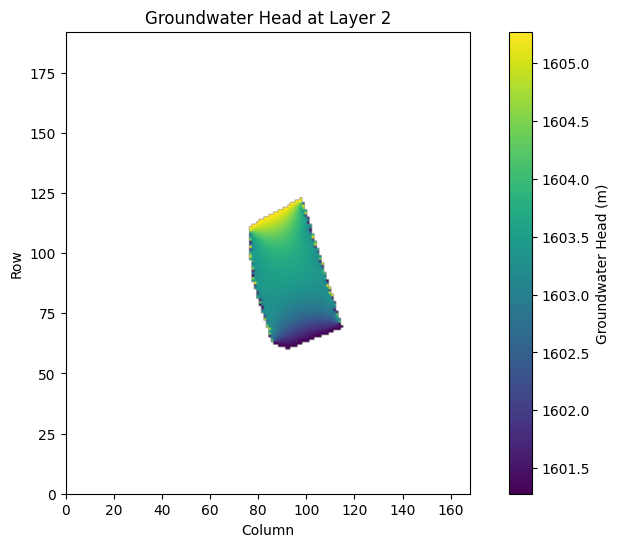

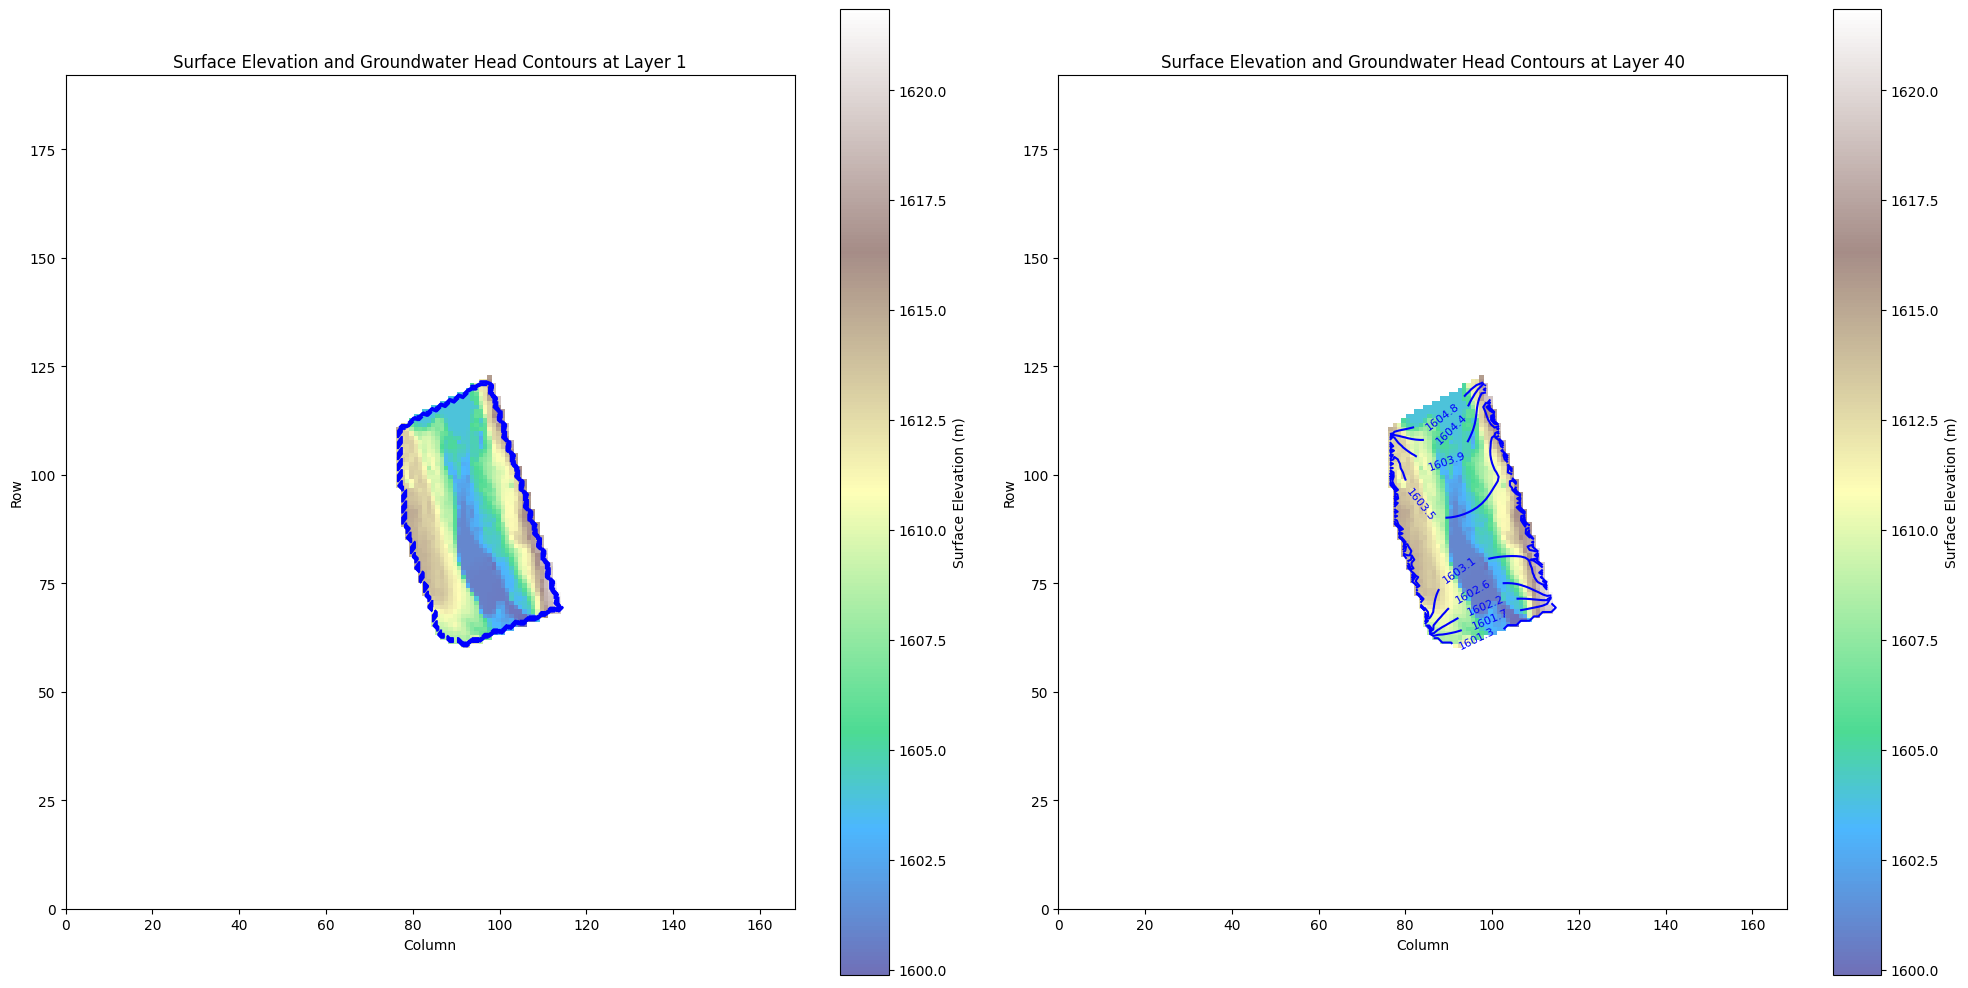

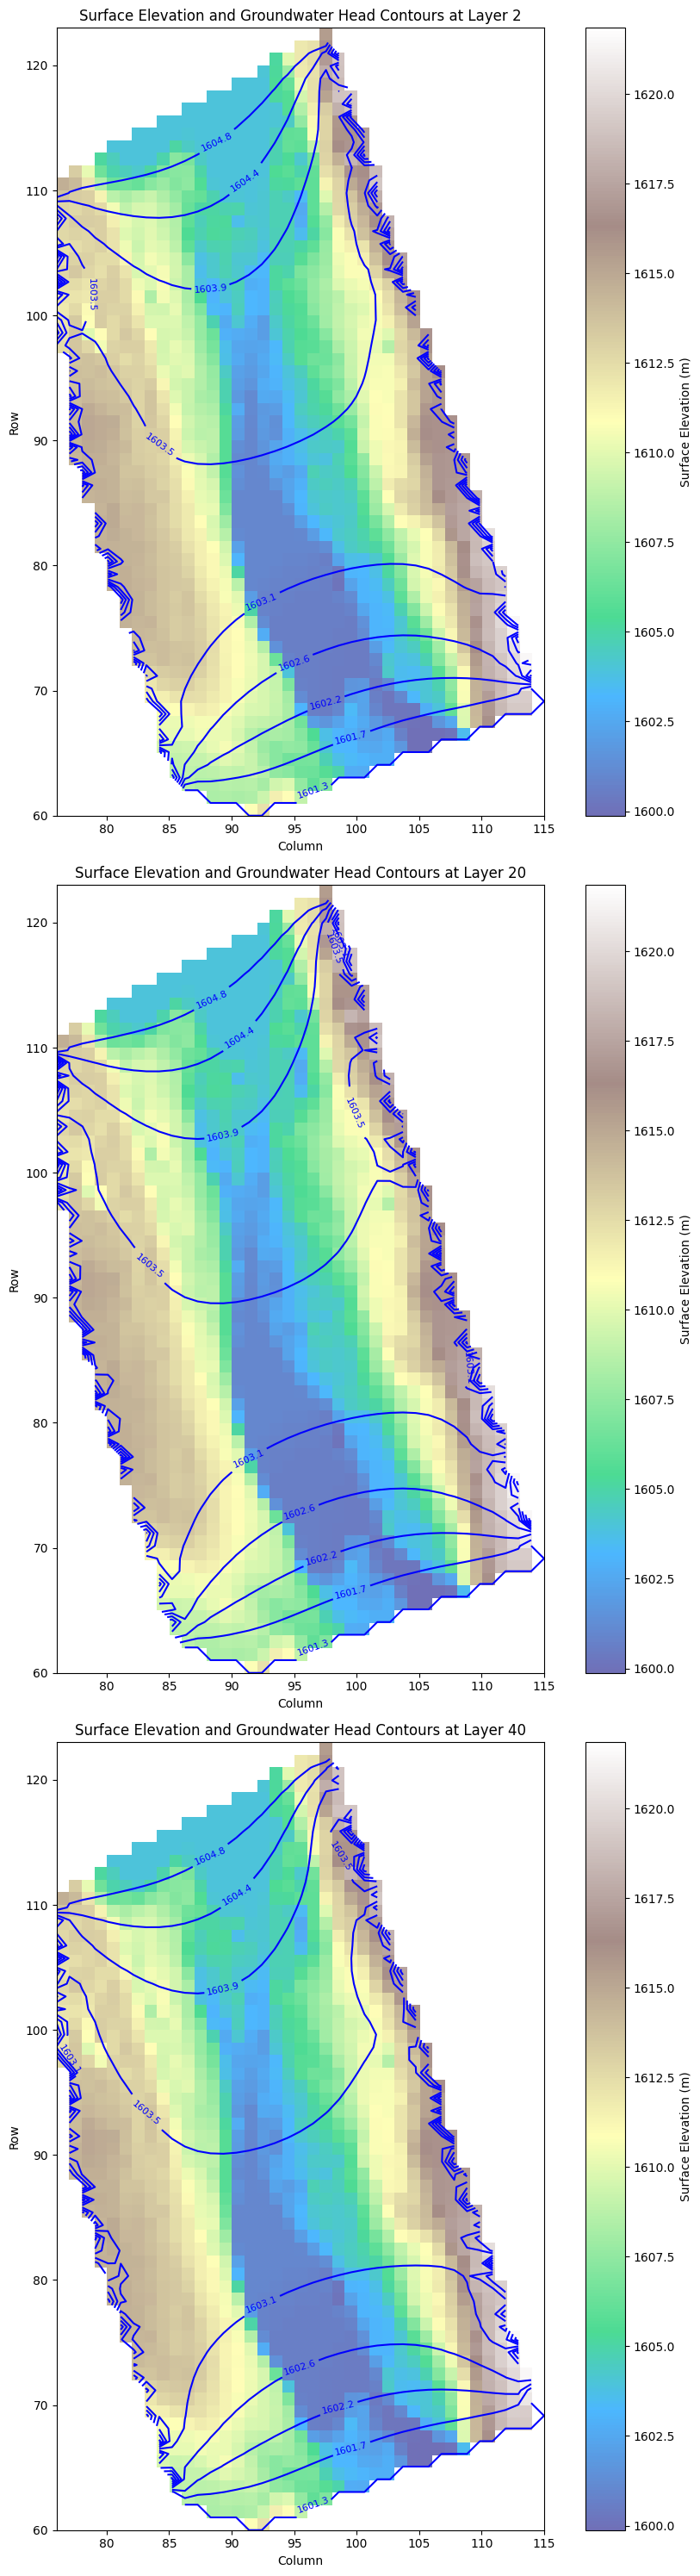

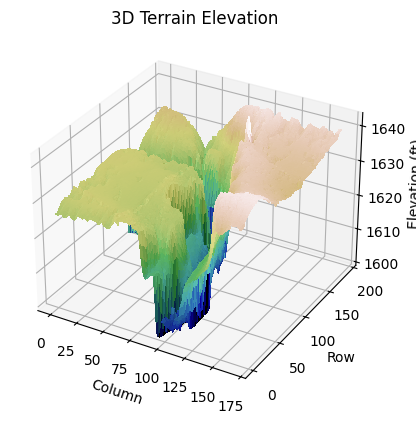

Building PRT model for Hyporheic_Project
An error occurred while building, running, or plotting the particle models: An error occurred in data element "packagedata" model "prt_model" package "prp1b". The error occurred while setting data in the "__init__" method.
Additional Information:
(1) Error occurred while adding dataset "packagedata" to block "packagedata"


In [132]:
#---------------------- Simulation Scenario ------------------------#
def scenario(silent=False):
    # Build the GWF model
    gwfsim, gwf = build_gwf_model(sim_name)
    
    # Debug print to check if the GWF model is built
    print("GWF model built:", gwfsim)
    
    if write:
        write_models(gwfsim, silent=silent)
        
        # Debug print to check if files are written
        print("GWF files written to:", gwf_ws)
    
    if run:
        # Run the MODFLOW model
        print("Running MODFLOW model...")
        run_models(gwfsim, silent=silent)
        print("FINISHED! Running GWF MODFLOW 6")
    
    if plot:
        print("Plotting Groundwater Flow Model")
        plot_gwf_all(gwfsim)
    
    # Attempt to build, run, and plot the particle models
    try:
        prtsim, prt, mpsim, mp7 = build_particle_models(sim_name, gwf)
        
        # Debug print to check if particle models are built
        print("Particle models built:", prtsim, mpsim)
        
        if write:
            write_models(prtsim, mp7, silent=silent)
            
            # Debug print to check if files are written
            print("Particle model files written to:", prt_ws, mp7_ws)
        
        if run:
            # Run the particle models
            print("Running particle models...")
            print("Running PRT MODFLOW 6")
            run_models(prtsim, silent=silent)
            print("FINISHED! Running PRT MODFLOW 6")

            print("Running MODPATH 7")
            run_models(mp7, silent=silent)
            print("FINISHED! Running MODPATH 7")
        if plot:
            print("Plotting Particle Models")
            #plot_all(gwfsim)
    
    except Exception as e:
        print(f"An error occurred while building, running, or plotting the particle models: {e}")

# Example usage:
scenario(silent=True)